In [1]:
!pip install lightgbm
!pip install catboost
!pip install xgboost

import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Clearing the Results Log File 
results_file = 'model_performance_tracking.csv'

# Clear the file (overwrite with empty DataFrame)
if os.path.exists(results_file):
    os.remove(results_file)  # Remove the file if it exists
# Create a new empty DataFrame with the required headers
results_df = pd.DataFrame(columns=['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 
                                   'Hyperparameters', 'Notes'])
results_df.to_csv(results_file, index=False)  # Save the empty file

# Load training data and preprocess
data = pd.read_csv('train.csv')

## Preprocessing

In [2]:
# Remove irrelevant columns
data = data.drop(columns=['PatientID', 'DoctorInCharge'])

# Split features and target
X = data.drop(columns='Diagnosis')
y = data['Diagnosis']

categorical_features = [
    'Gender', 'Ethnicity', 'EducationLevel', 'Smoking',
    'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes',
    'Depression', 'HeadInjury', 'Hypertension', 'MemoryComplaints',
    'BehavioralProblems', 'Confusion', 'Disorientation',
    'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness',
]

X[categorical_features] = X[categorical_features].astype('category')

Justification for specifying categorical features when using catboost model:

Specifying categorical features explicitly in CatBoost is crucial because it enables the algorithm to leverage its advanced handling of categorical data, which differentiates it from other machine learning frameworks. Unlike traditional methods that require preprocessing steps such as one-hot encoding or label encoding, CatBoost uses specialized techniques like target-based encoding and oblivious trees to process categorical variables directly. These techniques ensure that the relationships within categorical data are preserved and captured effectively, reducing information loss. Furthermore, correctly specifying categorical features allows CatBoost to optimize tree splits and handle high-cardinality features efficiently, resulting in improved model accuracy and reduced training time. By processing categorical data natively, CatBoost minimizes the risk of overfitting caused by traditional encoding methods, making it particularly well-suited for datasets with mixed feature types. Without explicit specification, the model might treat categorical features as numerical, potentially introducing biases or failing to utilize the inherent structure of the data.

# EDA

## Check if the classes are balanced

In [3]:
print(y.mean())

0.3537234042553192


In [4]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=[0, 1], 
    y=y
)
class_weights = {0: class_weights[0], 1: class_weights[1]}
print(class_weights)

{0: 0.7736625514403292, 1: 1.413533834586466}


## Check for non-linear relationships

We use PDPs to identify if there is any non-linear relationships between any of the features and the target variable. PDPs show the marginal effect of a feature on the target, averaging out the influence of all other features. 

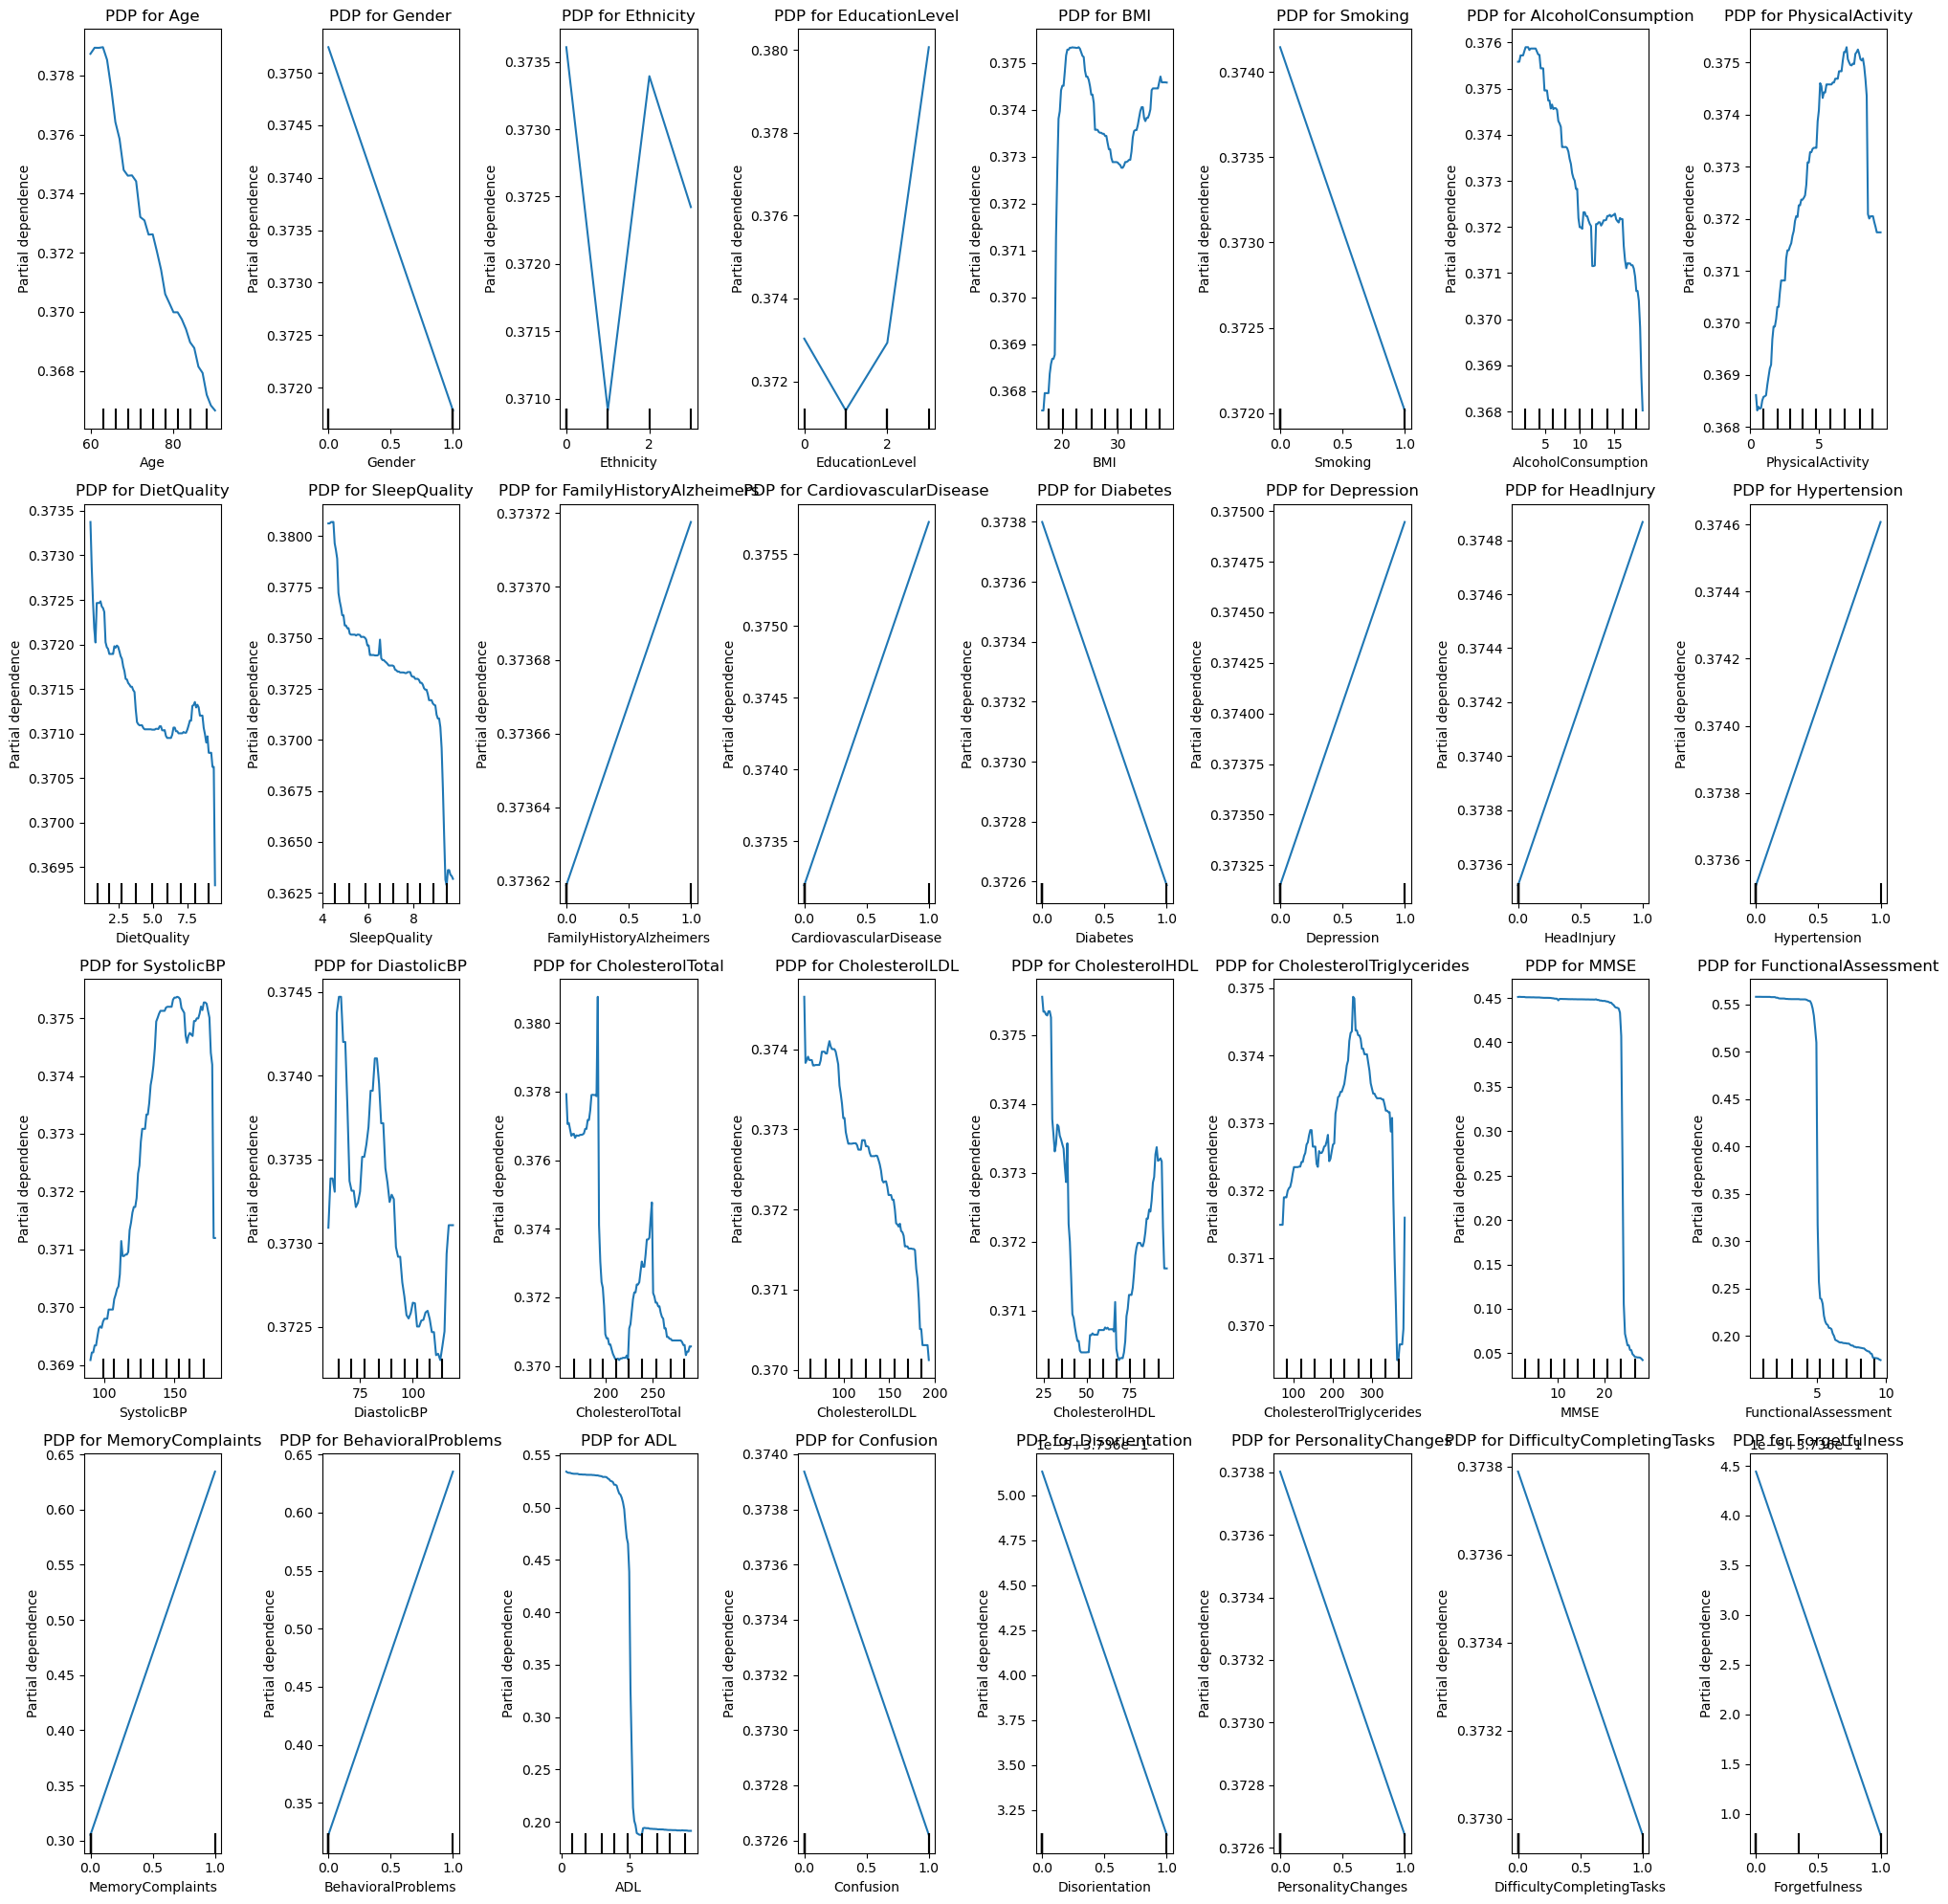

In [5]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
from math import ceil

model = CatBoostClassifier(class_weights=list(class_weights.values()),
                           cat_features=categorical_features, 
                           random_state=42, 
                           verbose=0)
model.fit(X, y)

# Select features to plot (numerical + important categorical ones)
features_to_plot = X.columns.tolist()  # You can also filter for specific features

# Number of rows and columns for the grid
num_features = len(features_to_plot)
num_cols = 8 #Number of columns in the grid
num_rows = ceil(num_features / num_cols)

# Set up the figure
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
axes = axes.ravel()

# Plot PDPs for all features
for i, feature in enumerate(features_to_plot):
    PartialDependenceDisplay.from_estimator(
        model,
        X,
        [feature],
        kind="average",
        ax=axes[i]  # Assign subplot
    )
    axes[i].set_title(f"PDP for {feature}")

# Hide empty subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show
output_image = "pdp_plots.png"

plt.tight_layout()
plt.show()

Training Logistic Regression...


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Random Forest...
Training CatBoost...
Training XGBoost...


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:51:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training SVM...


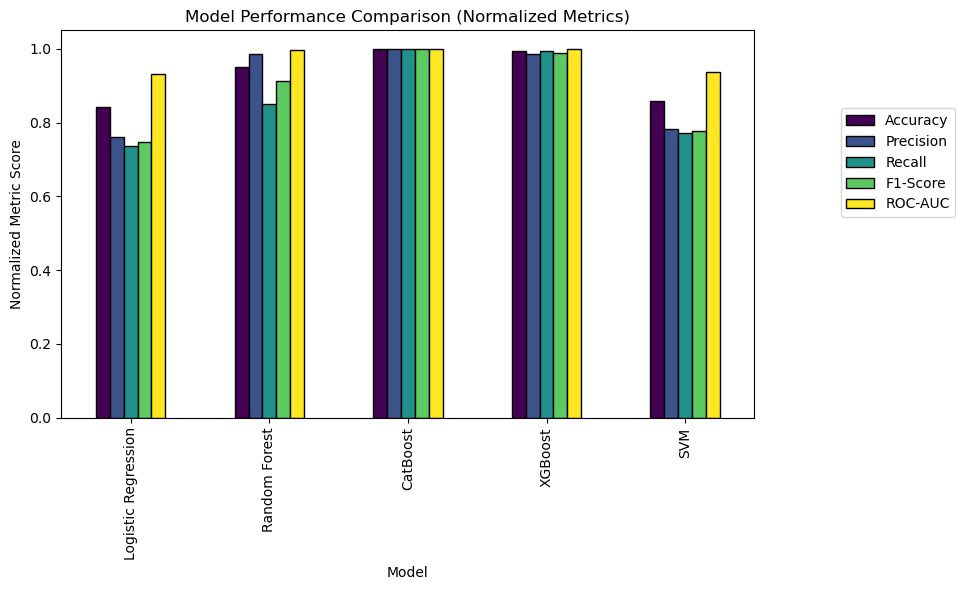

In [6]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, cat_features=list(X.select_dtypes(include='category').columns), random_state=42, verbose=0),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True, n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42),
    "SVM": SVC(probability=True, kernel='linear', random_state=42)
}

# Initialize storage for metrics
results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "ROC-AUC": []
}

# Evaluate models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    # Store results
    results["Model"].append(name)
    results["Accuracy"].append(accuracy)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["F1-Score"].append(f1)
    results["ROC-AUC"].append(roc_auc)

# Create DataFrame for results
results_df = pd.DataFrame(results)

# Normalize metrics for visualization
normalized_results = results_df.set_index("Model")
normalized_results = normalized_results / normalized_results.max()

# Plot results
normalized_results.plot(kind='bar', figsize=(10, 6), colormap='viridis', edgecolor='black')
plt.title("Model Performance Comparison (Normalized Metrics)")
plt.ylabel("Normalized Metric Score")
plt.xlabel("Model")
plt.legend(loc='lower right', bbox_to_anchor=(1.3, 0.5))
plt.tight_layout()
plt.show()


## Prioritize Feature Transformation for Most Important Features 

### Identify the Top Features using Catboost Model

In [7]:
from catboost import CatBoostClassifier
import pandas as pd

# Initialize and train the model
model = CatBoostClassifier(class_weights=list(class_weights.values()), 
                           cat_features=categorical_features, 
                           random_state=42, 
                           verbose=0)
model.fit(X, y)

# Get feature importance
feature_importances = model.get_feature_importance(prettified=True)

# Convert to a DataFrame for easy manipulation
feature_importances_df = pd.DataFrame(feature_importances)
feature_importances_df.columns = ['Feature', 'Importance']

# Sort by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Display the importance matrix
print(feature_importances_df)

                      Feature  Importance
0        FunctionalAssessment   22.245601
1                         ADL   18.881688
2                        MMSE   18.182639
3            MemoryComplaints   13.178329
4          BehavioralProblems    9.693183
5              CholesterolHDL    1.574578
6          AlcoholConsumption    1.375019
7                 DietQuality    1.342695
8                   Ethnicity    1.264106
9                         Age    1.230995
10             EducationLevel    1.229068
11           PhysicalActivity    1.189770
12           CholesterolTotal    1.113608
13   CholesterolTriglycerides    1.104929
14                 SystolicBP    1.074025
15                        BMI    1.061997
16               SleepQuality    1.039590
17             CholesterolLDL    0.953320
18                DiastolicBP    0.822514
19                     Gender    0.280116
20                    Smoking    0.206513
21                 Depression    0.133096
22      CardiovascularDisease    0

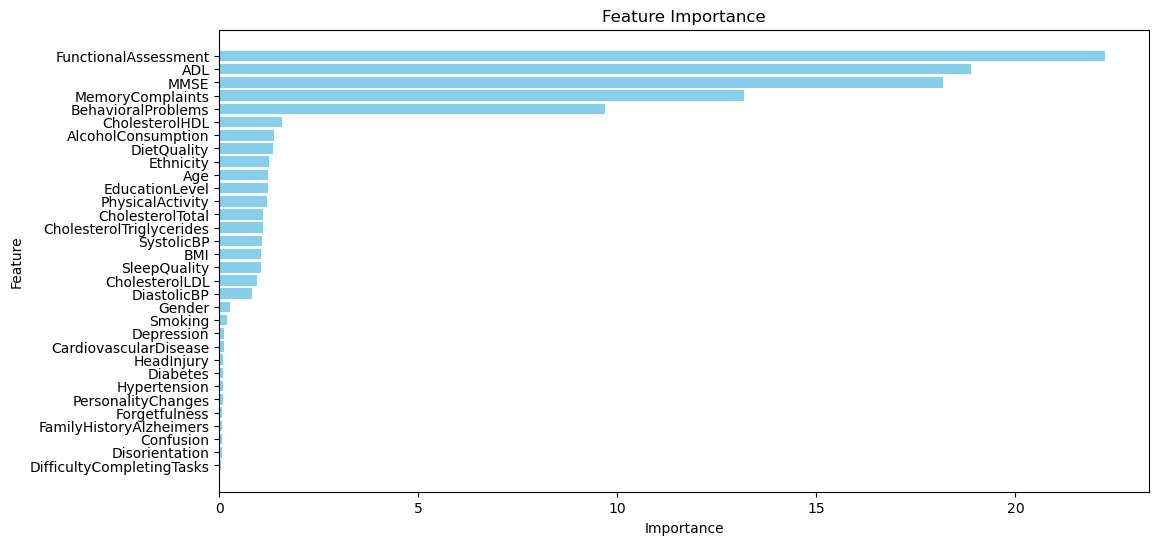

In [8]:
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()


## Prioritize Transformation for Top 5 Features
FunctionalAssessment, ADL, MMSE, MemoryComplaints, BehavioralProblems

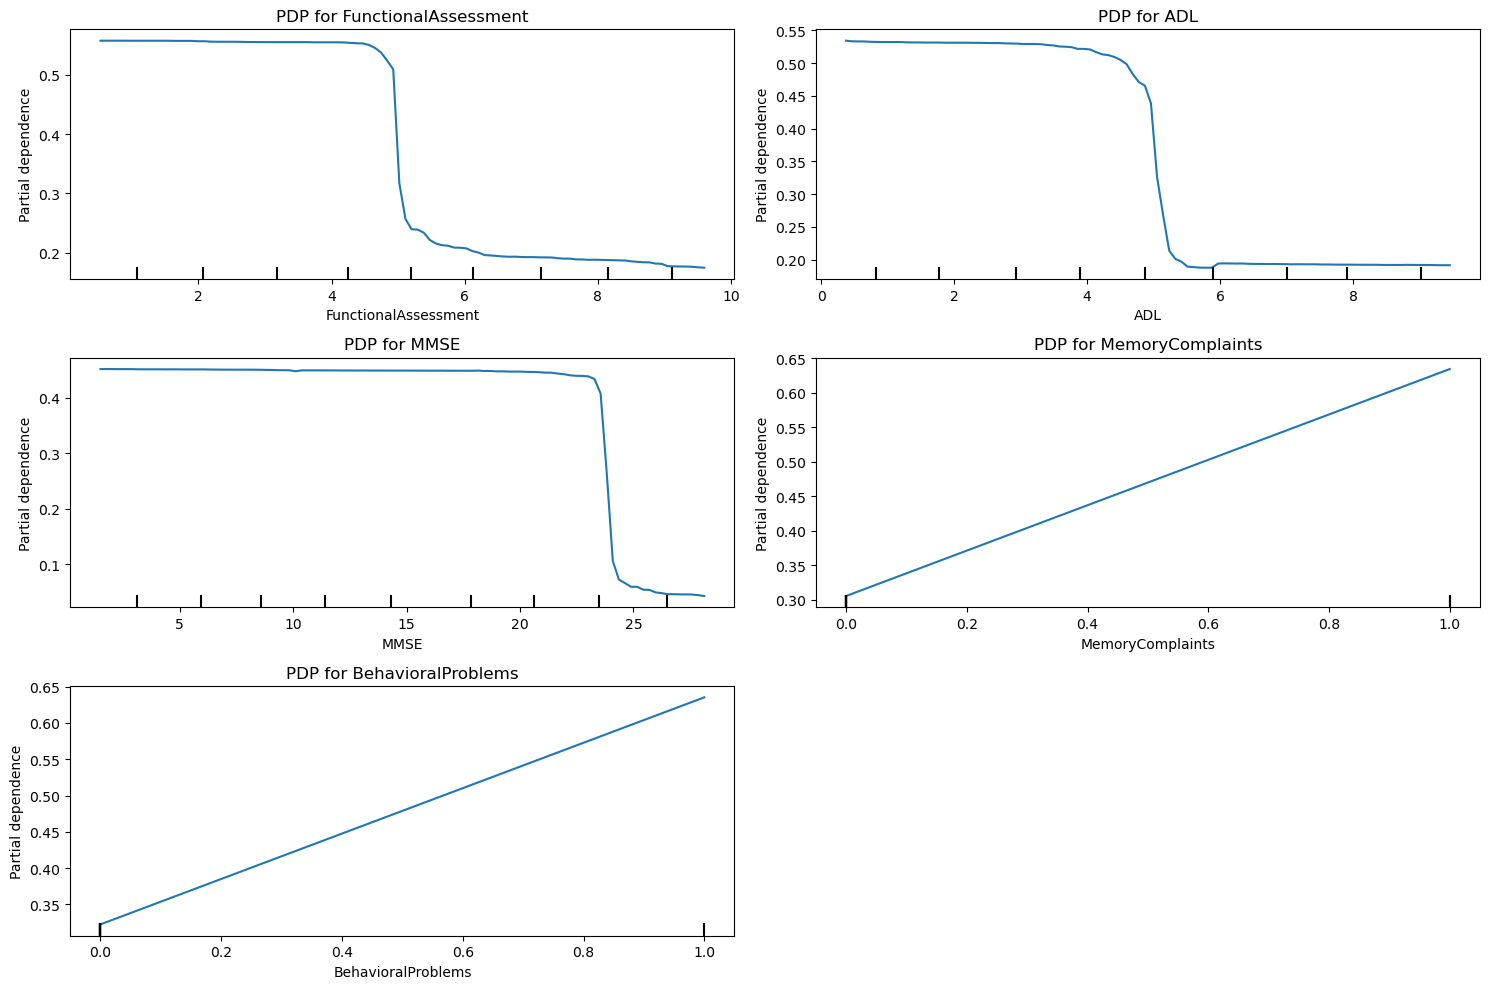

In [9]:
import matplotlib.pyplot as plt

# Define the top 5 features
top_5_features = ['FunctionalAssessment', 'ADL', 'MMSE', 'MemoryComplaints', 'BehavioralProblems']

# Set up a 3x2 grid for the plots
num_features = len(top_5_features)
num_cols = 2  # Number of columns
num_rows = 3  # Number of rows (enough to fit all 5 features)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.ravel()  # Flatten the axes for easier indexing

# Train the CatBoost model if not already trained
model = CatBoostClassifier(class_weights=list(class_weights.values()), 
                           cat_features=categorical_features, 
                           random_state=42, 
                           verbose=0)
model.fit(X, y)

# Generate PDPs for the top 5 features
for i, feature in enumerate(top_5_features):
    PartialDependenceDisplay.from_estimator(
        model,
        X,
        [feature],
        kind="average",
        ax=axes[i]  # Assign each plot to a specific subplot
    )
    axes[i].set_title(f"PDP for {feature}")

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

PDP furve for FunctionalAssessment and ADL both show a threshold effect at value 5, which may imply potentially multicollinearity. 

In [10]:
# Calculate correlation between FunctionalAssessment and ADL
correlation = X[['FunctionalAssessment', 'ADL']].corr()
print("Correlation Matrix:\n", correlation)

Correlation Matrix:
                       FunctionalAssessment       ADL
FunctionalAssessment              1.000000  0.065094
ADL                               0.065094  1.000000


Since the two variables are not strongly correlated, meaning they capture largely independent information. The similar pattern in their PDPs is likely due to a shared threshhold effect rather than redundancy. We preoceed with investigating their threshold effects. 

# Baseline Model

## K-Fold Cross Validation

In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score


# Initialize CatBoost model
cat_model_baseline = CatBoostClassifier(class_weights=list(class_weights.values()), 
                               cat_features=categorical_features, 
                               random_state=42, 
                               verbose=0)

# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
auc_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform K-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    cat_model_baseline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = cat_model_baseline.predict(X_test)
    y_pred_proba = cat_model_baseline.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    
    # Calculate metrics
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    # Store metrics
    auc_scores.append(auc)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Compute average performance metrics
mean_auc = sum(auc_scores) / len(auc_scores)
mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
mean_precision = sum(precision_scores) / len(precision_scores)
mean_recall = sum(recall_scores) / len(recall_scores)
mean_f1 = sum(f1_scores) / len(f1_scores)

# Print overall results
print("\nK-Fold Cross-Validation Results:")
print(f"Mean AUC: {mean_auc:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f}")

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

K-Fold Cross-Validation Results:
Mean AUC: 0.9531
Mean Accuracy: 0.9581
Mean Precision: 0.9489
Mean Recall: 0.9327
Mean F1-Score: 0.9407


## Log Model 1 - Baseline Model

In [12]:
# File path to save and load results
results_file = 'model_performance_tracking.csv'

# Initialize results DataFrame if it doesn't exist
if not os.path.exists(results_file):
    results_df = pd.DataFrame(columns=['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 
                                       'Hyperparameters', 'Notes'])
else:
    # Load existing results
    results_df = pd.read_csv(results_file)

# Log the model's results
hyperparameters = cat_model_baseline.get_params()
new_entry = pd.DataFrame([{
    'Model': 'Model 1: Baseline Model',
    'AUC': mean_auc,
    'Accuracy': mean_accuracy,
    'Precision': mean_precision,
    'Recall': mean_recall,
    'F1-Score': mean_f1,
    'Hyperparameters': str(hyperparameters),  # Convert hyperparameters to string
    'Notes': '5-fold cross-validation with default hyperparameters'
}])

# Append the new entry to the existing results DataFrame
results_df = pd.concat([results_df, new_entry], ignore_index=True)

# Save the updated results DataFrame to the CSV file
results_df.to_csv(results_file, index=False)

print("Model results logged successfully!")

Model results logged successfully!


/tmp/ipykernel_6598/1651344590.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_entry], ignore_index=True)


In [13]:
print(results_df)

                     Model     AUC  Accuracy  Precision    Recall  F1-Score  \
0  Model 1: Baseline Model  0.9531  0.958102   0.948947  0.932688  0.940655   

                                     Hyperparameters  \
0  {'verbose': 0, 'class_weights': [0.77366255144...   

                                               Notes  
0  5-fold cross-validation with default hyperpara...  


# Model 2

## Hyperparameter Tuning

In [14]:
# # Define the parameter grid for tuning
# param_grid = {
#     'iterations': [500, 1000],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'depth': [4, 6, 8],
#     'l2_leaf_reg': [1, 3, 5],
#     'bagging_temperature': [0.2, 0.5, 1],
# }

# # Wrap CatBoost in a compatible scikit-learn estimator for GridSearchCV
# cat_model_baseline = CatBoostClassifier(class_weights=list(class_weights.values()), cat_features=categorical_features, random_state=42, verbose=0)

# # Perform Grid Search
# grid_search = GridSearchCV(estimator=cat_model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=3, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Output the best parameters and the corresponding score
# print(f"Best Hyperparameters: {grid_search.best_params_}")
# print(f"Best AUC Score from Grid Search: {grid_search.best_score_}")

## Retrain Model with the Resulting Hyperparameters from Hyperparameter Tuning

In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# Best hyperparameters from grid search
best_params = {
    'bagging_temperature': 0.2,
    'depth': 4,
    'iterations': 500,
    'l2_leaf_reg': 3,
    'learning_rate': 0.05,
    'random_state': 42,
    'verbose': 0
}

# Initialize CatBoost model with tuned hyperparameters
cat_model_baseline_tuned = CatBoostClassifier(class_weights=list(class_weights.values()), 
                               cat_features=categorical_features, 
                                     **best_params)


# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
auc_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform K-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    cat_model_baseline_tuned.fit(X_train, y_train, cat_features=categorical_features)
    
    # Make predictions
    y_pred = cat_model_baseline_tuned.predict(X_test)
    y_pred_proba = cat_model_baseline_tuned.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    
    # Calculate metrics
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    # Store metrics
    auc_scores.append(auc)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Compute average performance metrics
mean_auc = sum(auc_scores) / len(auc_scores)
mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
mean_precision = sum(precision_scores) / len(precision_scores)
mean_recall = sum(recall_scores) / len(recall_scores)
mean_f1 = sum(f1_scores) / len(f1_scores)

# Print overall results
print("\nK-Fold Cross-Validation Results for Tuned Model:")
print(f"Mean AUC: {mean_auc:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f}")

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

K-Fold Cross-Validation Results for Tuned Model:
Mean AUC: 0.9540
Mean Accuracy: 0.9581
Mean Precision: 0.9490
Mean Recall: 0.9327
Mean F1-Score: 0.9407


## Log Model 2 - Baseline Model with Hyperparameter Tuning

In [16]:
## Outputting to log file

import os

# File path to save and load results
results_file = 'model_performance_tracking.csv'

# Initialize results DataFrame if it doesn't exist
if not os.path.exists(results_file):
    results_df = pd.DataFrame(columns=['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 
                                       'Hyperparameters', 'Notes'])
else:
    # Load existing results
    results_df = pd.read_csv(results_file)

# Log the tuned model's results
new_entry = pd.DataFrame([{
    'Model': 'Model 2: Baseline Model with Hyperparameter Tuning)',
    'AUC': mean_auc,
    'Accuracy': mean_accuracy,
    'Precision': mean_precision,
    'Recall': mean_recall,
    'F1-Score': mean_f1,
    'Hyperparameters': "{'bagging_temperature': 0.2, 'depth': 4, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.05}",
    'Notes': '5-fold cross-validation with tuned hyperparameters'
}])


# Append the new entry to the existing results DataFrame
results_df = pd.concat([results_df, new_entry], ignore_index=True)

# Save the updated results DataFrame to the CSV file
results_df.to_csv(results_file, index=False)

print("Tuned model results logged successfully!")

Tuned model results logged successfully!


In [17]:
from IPython.display import display

# Display the DataFrame
display(results_df)

,Model,AUC,Accuracy,Precision,Recall,F1-Score,Hyperparameters,Notes
0,Model 1: Baseline Model,0.953100,0.958102,0.948947,0.932688,0.940655,"{'verbose': 0, 'class_weights': [0.77366255144...",5-fold cross-validation with default hyperpara...
1,Model 2: Baseline Model with Hyperparameter Tu...,0.954045,0.958102,0.948955,0.932688,0.940660,"{'bagging_temperature': 0.2, 'depth': 4, 'iter...",5-fold cross-validation with tuned hyperparame...


## Generate Predictions for Test Data - Baseline Model

In [18]:
# Load the test dataset
test_data = pd.read_csv('test.csv')

# Extract PatientID for output
patient_ids = test_data['PatientID']
test_features = test_data.drop(columns=['PatientID', 'DoctorInCharge'], errors='ignore')

# Generate predictions for CatBoost
cat_test_predictions = cat_model_baseline.predict(test_features)
cat_output = pd.DataFrame({
    'PatientID': patient_ids,
    'Diagnosis': cat_test_predictions
})
cat_output.to_csv('predictions_catboost.csv', index=False)

print("Predictions saved to 'predictions_catboost.csv'")

Predictions saved to 'predictions_catboost.csv'


## Generate Predictions for Test Data - Tuned Model

In [19]:
# Load the test dataset
test_data = pd.read_csv('test.csv')

# Extract PatientID for output
patient_ids = test_data['PatientID']
test_features = test_data.drop(columns=['PatientID', 'DoctorInCharge'], errors='ignore')

# Generate predictions for CatBoost
cat_test_tuned_predictions = cat_model_baseline_tuned.predict(test_features)
cat_output = pd.DataFrame({
    'PatientID': patient_ids,
    'Diagnosis': cat_test_tuned_predictions
})
cat_output.to_csv('predictions_catboost_tuned.csv', index=False)

print("Predictions saved to 'predictions_catboost_tuned.csv'")

Predictions saved to 'predictions_catboost_tuned.csv'


## Comparing Prediction Results

In [20]:
# Create a DataFrame to compare predictions
comparison_df = pd.DataFrame({
    'PatientID': patient_ids,
    'Baseline_Diagnosis': cat_test_predictions,
    'Tuned_Diagnosis': cat_test_tuned_predictions
})

# Add a column to highlight differences
comparison_df['Differ'] = comparison_df['Baseline_Diagnosis'] != comparison_df['Tuned_Diagnosis']

# Print the differences summary
num_differences = comparison_df['Differ'].sum()
print(num_differences)

3


## Comparing Hyperparameters

In [21]:

# Specify the hyperparameters to compare
hyperparameters_to_compare = [
    'bagging_temperature', 
    'depth', 
    'iterations', 
    'l2_leaf_reg', 
    'learning_rate', 
    'random_state', 
    'verbose'
]

# Extract the hyperparameters from the baseline and tuned models
baseline_params = cat_model_baseline.get_params()
tuned_params = cat_model_baseline_tuned.get_params()

# Extract default values for baseline parameters if not explicitly set
default_params = {
    'bagging_temperature': 1.0,
    'depth': 6,
    'iterations': 1000,
    'l2_leaf_reg': 3,
    'learning_rate': 0.03,  # Approximate default
    'random_state': None,   # Default is None if not set
    'verbose': 0            # Silent mode enabled
}

# Replace missing baseline parameters with their defaults
baseline_values = [
    baseline_params.get(param, default_params.get(param, "N/A"))
    for param in hyperparameters_to_compare
]

# Create a DataFrame to compare the selected hyperparameters
hyperparameter_comparison = pd.DataFrame({
    'Hyperparameter': hyperparameters_to_compare,
    'Baseline_Model': baseline_values,
    'Tuned_Model': [tuned_params.get(param, "N/A") for param in hyperparameters_to_compare],
    'Differ': [
        baseline_params.get(param, default_params.get(param, "N/A")) != tuned_params.get(param, "N/A")
        for param in hyperparameters_to_compare
    ]  # Highlight differences
})

# Save the comparison to a CSV file
# hyperparameter_comparison.to_csv('hyperparameter_comparison_selected.csv', index=False)

# Display the comparison
print("Selected Hyperparameter Comparison:")
print(hyperparameter_comparison.to_string(index=False))

print("\nComparison saved to 'hyperparameter_comparison_selected.csv'")

Selected Hyperparameter Comparison:
     Hyperparameter  Baseline_Model  Tuned_Model  Differ
bagging_temperature            1.00         0.20    True
              depth            6.00         4.00    True
         iterations         1000.00       500.00    True
        l2_leaf_reg            3.00         3.00   False
      learning_rate            0.03         0.05    True
       random_state           42.00        42.00   False
            verbose            0.00         0.00   False

Comparison saved to 'hyperparameter_comparison_selected.csv'


# Model 3 - Catboost with Feature Selection & Hyperparameter Tuning

## Feature Selection via Catboost Feature Elimination

In [22]:
# # Import necessary libraries
# from sklearn.model_selection import cross_val_score, KFold
# import numpy as np
# from catboost import CatBoostClassifier
# import pandas as pd

# # Define the fixed list of categorical features
# categorical_features = [
#     'Gender', 'Ethnicity', 'EducationLevel', 'Smoking',
#     'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes',
#     'Depression', 'HeadInjury', 'Hypertension', 'MemoryComplaints',
#     'BehavioralProblems', 'Confusion', 'Disorientation',
#     'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness'
# ]

# # Preprocess categorical features
# for col in categorical_features:
#     if col in X.columns:
#         X[col] = X[col].astype('category')  # Ensure correct type
#         if 'Unknown' not in X[col].cat.categories:  # Add 'Unknown' as a valid category
#             X[col] = X[col].cat.add_categories('Unknown')
#         X[col] = X[col].fillna('Unknown')  # Replace NaN with 'Unknown'

# # Define CatBoost model parameters
# estimator_params = {
#     'random_state': 42,
#     'verbose': 0,
#     'iterations': 500,
#     'depth': 6,
#     'learning_rate': 0.05,
#     'eval_metric': 'AUC'
# }

# # Define the manual RFECV function
# def manual_rfecv(X, y, categorical_features, estimator_params, min_features_to_select=1):
#     features = X.columns.tolist()
#     best_auc = 0
#     best_features = features.copy()

#     while len(features) > min_features_to_select:
#         print(f"Evaluating {len(features)} features...")

#         # Train model and calculate cross-validated AUC
#         model = CatBoostClassifier(cat_features=[features.index(col) for col in categorical_features if col in features],
#                                    **estimator_params)
#         scores = cross_val_score(
#             model,
#             X[features],
#             y,
#             scoring='roc_auc',
#             cv=KFold(n_splits=5, shuffle=True, random_state=42),
#             error_score='raise'
#         )
#         mean_auc = scores.mean()

#         print(f"Mean AUC with {len(features)} features: {mean_auc:.4f}")

#         # Check if this set of features is the best
#         if mean_auc > best_auc:
#             best_auc = mean_auc
#             best_features = features.copy()

#         # Identify the least important feature and remove it
#         model.fit(X[features], y)
#         feature_importances = model.get_feature_importance(type='FeatureImportance')
#         least_important_feature = features[np.argmin(feature_importances)]
#         print(f"Removing least important feature: {least_important_feature}")
#         features.remove(least_important_feature)

#     return best_features, best_auc

# # Perform Recursive Feature Elimination
# best_features, best_auc = manual_rfecv(X, y, categorical_features, estimator_params)

# # Output results
# print(f"\nBest Features ({len(best_features)}): {best_features}")
# print(f"Best Mean AUC: {best_auc:.4f}")


## Train Model with Selected Features
Selected Features: AlcoholConsumption, CholesterolTotal, MMSE, FunctionalAssessment, MemoryComplaints, BehavioralProblems, ADL

In [23]:
best_features = ['AlcoholConsumption', 'SleepQuality', 'SystolicBP', 'CholesterolTotal', 'CholesterolHDL', 
                 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 
                 'BehavioralProblems', 'ADL']

estimator_params = {
    'random_state': 42,
    'verbose': 0,
    'iterations': 500,
    'depth': 6,
    'learning_rate': 0.05
}

X_best = X[best_features]

# Train and validate the final model
cat_cfecv = CatBoostClassifier(class_weights=list(class_weights.values()),
                               cat_features=categorical_features, 
                               **estimator_params)

## Hyperparameter Tuning

In [24]:
# param_grid = {
#     'iterations': [500, 1000, 1500],  # Number of boosting iterations
#     'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
#     'depth': [4, 6, 8],  # Maximum tree depth
#     'l2_leaf_reg': [1, 3, 5],  # L2 regularization
#     'bagging_temperature': [0.2, 0.5, 1]  # Bagging randomness
# }

# from sklearn.model_selection import GridSearchCV

# # Initialize the CatBoost model
# cat_cfecv = CatBoostClassifier(class_weights=list(class_weights.values()),
#                                cat_features=['MemoryComplaints', 'BehavioralProblems'], 
#                                random_state=42, 
#                                verbose=0)

# # Perform Grid Search on the reduced feature set
# grid_search = GridSearchCV(
#     estimator=cat_cfecv,
#     param_grid=param_grid,
#     cv=5,  # 5-fold cross-validation
#     scoring='roc_auc',  # Optimize for ROC AUC
#     verbose=3,
#     n_jobs=-1
# )

# # Fit Grid Search to the reduced feature set
# grid_search.fit(X_best, y)

# # Best parameters and score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print(f"Best Hyperparameters: {best_params}")
# print(f"Best ROC AUC Score: {best_score:.4f}")

In [25]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# Specify best hyperparameters
best_params = {
    'bagging_temperature': 0.2,
    'depth': 4,
    'iterations': 500,
    'l2_leaf_reg': 5,
    'learning_rate': 0.01,
    'random_state': 42,
    'verbose': 0,
}

# Initialize and train the final CatBoost model
cat_cfecv_tuned = CatBoostClassifier(class_weights=list(class_weights.values()), 
                               cat_features=['MemoryComplaints', 'BehavioralProblems'],
                                     **best_params)
cat_cfecv_tuned.fit(X_best, y)

# Generate predictions
y_pred = cat_cfecv_tuned.predict(X_best)
y_pred_proba = cat_cfecv_tuned.predict_proba(X_best)[:, 1]  # Probabilities for the positive class

# Calculate performance metrics
mean_auc = roc_auc_score(y, y_pred_proba)
mean_accuracy = accuracy_score(y, y_pred)
mean_precision = precision_score(y, y_pred, zero_division=0)
mean_recall = recall_score(y, y_pred, zero_division=0)
mean_f1 = f1_score(y, y_pred, zero_division=0)

# Print evaluation results
print(f"cat_cfecv_tuned Metrics:")
print(f"ROC AUC: {mean_auc:.4f}")
print(f"Accuracy: {mean_accuracy:.4f}")
print(f"Precision: {mean_precision:.4f}")
print(f"Recall: {mean_recall:.4f}")
print(f"F1-Score: {mean_f1:.4f}")

cat_cfecv_tuned Metrics:
ROC AUC: 0.9781
Accuracy: 0.9621
Precision: 0.9541
Recall: 0.9380
F1-Score: 0.9460


## Log results for Model 3 - Feature Selection using CFECV

In [26]:
# Log the model's results
hyperparameters = cat_cfecv_tuned.get_params()
new_entry = pd.DataFrame([{
    'Model': 'Model 3: Catboost with Feature Selection',
    'AUC': mean_auc,
    'Accuracy': mean_accuracy,
    'Precision': mean_precision,
    'Recall': mean_recall,
    'F1-Score': mean_f1,
    'Hyperparameters': str(hyperparameters),  # Convert hyperparameters to string
    'Notes': 'Trained with selected features and tuned hyperparameters'
}])

# Append the new entry to the existing results DataFrame
results_df = pd.concat([results_df, new_entry], ignore_index=True)

# Save the updated results DataFrame to the CSV file
results_df.to_csv(results_file, index=False)

print("Model results logged successfully!")

Model results logged successfully!


## Generate Predictions for Test Dataset

In [27]:
# Load the test dataset
test_data = pd.read_csv('test.csv')

# Extract PatientID for output
patient_ids = test_data['PatientID']

# Subset test data to only include optimal features
test_features = test_data[best_features]

cat_cfecv_tuned_predictions = cat_cfecv_tuned.predict(test_features)
cat_output = pd.DataFrame({
    'PatientID': patient_ids,
    'Diagnosis': cat_cfecv_tuned_predictions
})
cat_output.to_csv('predictions_catboost_cfecv_tuned.csv', index=False)

print("Predictions saved to 'predictions_catboost_cfecv_tuned.csv'")

Predictions saved to 'predictions_catboost_cfecv_tuned.csv'


# Model 4.1, 4.2, 4.3 - Feature Engineering (Threshold Effects)

## Identify the optimal threshold for FunctionalAssessment, ADL and MMSE

Optimal threshold for FunctionalAssessment: 4.93
Optimal threshold for ADL: 4.96
Optimal threshold for MMSE: 23.82


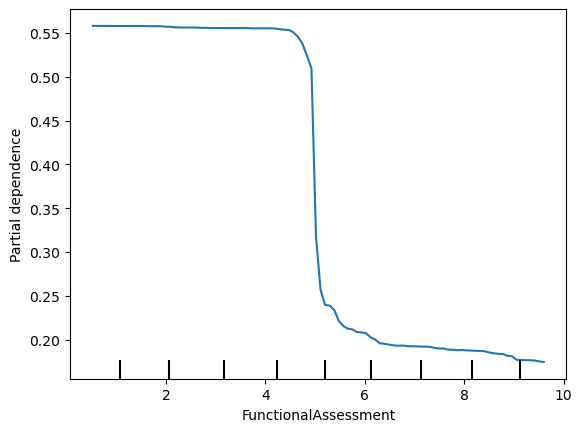

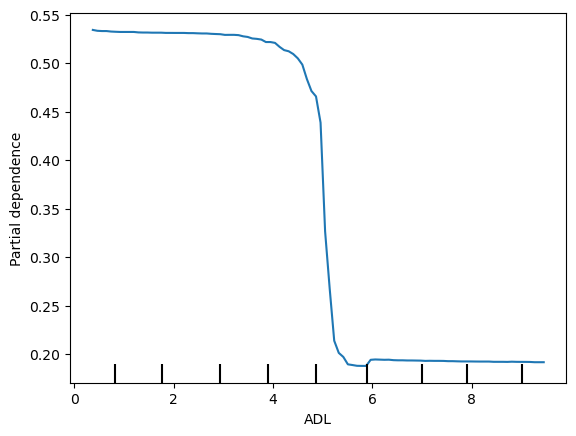

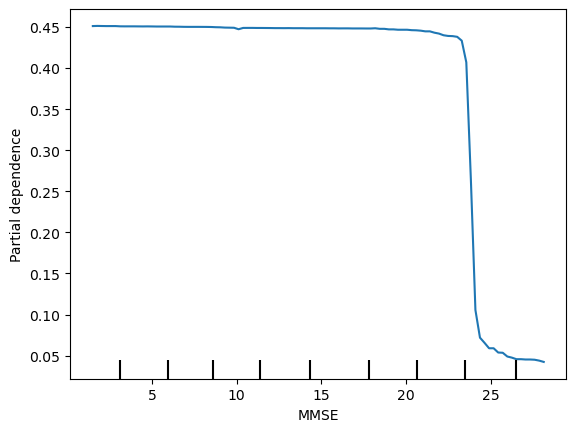

In [28]:
from sklearn.inspection import PartialDependenceDisplay
import numpy as np

# Function to calculate optimal threshold from PDP
def calculate_optimal_threshold(model, X, feature_name):
    # Generate Partial Dependence Plot data
    pdp = PartialDependenceDisplay.from_estimator(
        model, X, [feature_name], kind="average"
    )

    # Extract the PDP data
    feature_pdp = pdp.lines_[0][0].get_ydata()
    feature_values = pdp.lines_[0][0].get_xdata()

    # Calculate differences (gradient of the curve)
    differences = np.diff(feature_pdp)

    # Find the index of the largest change
    threshold_index = np.argmax(np.abs(differences))
    optimal_threshold = feature_values[threshold_index]

    return optimal_threshold

# Train the model
model = CatBoostClassifier(class_weights=list(class_weights.values()),
                                     cat_features=categorical_features,
                           random_state=42, verbose=0)
model.fit(X, y)

# Calculate thresholds for each feature
optimal_threshold_fa = calculate_optimal_threshold(model, X, "FunctionalAssessment")
optimal_threshold_adl = calculate_optimal_threshold(model, X, "ADL")
optimal_threshold_mmse = calculate_optimal_threshold(model, X, "MMSE")

print(f"Optimal threshold for FunctionalAssessment: {optimal_threshold_fa:.2f}")
print(f"Optimal threshold for ADL: {optimal_threshold_adl:.2f}")
print(f"Optimal threshold for MMSE: {optimal_threshold_mmse:.2f}")


## Model 4.1 - replace the original features with the transformed features  

In [29]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from catboost import CatBoostClassifier

# Replace features with binary threshold transformations
X_transformed = X.copy()
X_transformed['FunctionalAssessment'] = (X_transformed['FunctionalAssessment'] > 4.93).astype(int)
X_transformed['ADL'] = (X_transformed['ADL'] > 4.96).astype(int)
X_transformed['MMSE'] = (X_transformed['MMSE'] > 23.82).astype(int)

# Initialize CatBoost model
cat_model_41 = CatBoostClassifier(class_weights=list(class_weights.values()),
                                  cat_features=categorical_features,
                               random_state=42, 
                               verbose=0)

# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
auc_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform K-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(X_transformed)):
    print(f"Fold {fold + 1}")
    X_train, X_test = X_transformed.iloc[train_index], X_transformed.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    cat_model_41.fit(X_train, y_train)
    
    # Make predictions
    y_pred = cat_model_41.predict(X_test)
    y_pred_proba = cat_model_41.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    
    # Calculate metrics
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    # Store metrics
    auc_scores.append(auc)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Compute average performance metrics
mean_auc = sum(auc_scores) / len(auc_scores)
mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
mean_precision = sum(precision_scores) / len(precision_scores)
mean_recall = sum(recall_scores) / len(recall_scores)
mean_f1 = sum(f1_scores) / len(f1_scores)

# Print overall results
print("\nK-Fold Cross-Validation Results with Transformed Features:")
print(f"Mean AUC: {mean_auc:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f}")


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

K-Fold Cross-Validation Results with Transformed Features:
Mean AUC: 0.9500
Mean Accuracy: 0.9568
Mean Precision: 0.9540
Mean Recall: 0.9234
Mean F1-Score: 0.9383


## Log Model 1 - replaced the original features with their corresponding threshold dummies

In [30]:
# File path to save and load results
results_file = 'model_performance_tracking.csv'

# Initialize results DataFrame if it doesn't exist
if not os.path.exists(results_file):
    results_df = pd.DataFrame(columns=['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 
                                       'Hyperparameters', 'Notes'])
else:
    # Load existing results
    results_df = pd.read_csv(results_file)

# Log the model's results
new_entry = pd.DataFrame([{
    'Model': 'Model 4.1: Replaced the original features with their corresponding threshold dummies',
    'AUC': mean_auc,
    'Accuracy': mean_accuracy,
    'Precision': mean_precision,
    'Recall': mean_recall,
    'F1-Score': mean_f1,
    'Hyperparameters': str(best_params),  # Convert hyperparameters to string
    'Notes': 'Combined features (original + binary thresholds)'
}])

# Append the new entry to the existing results DataFrame
results_df = pd.concat([results_df, new_entry], ignore_index=True)

# Save the updated results DataFrame to the CSV file
results_df.to_csv(results_file, index=False)

print("Model results logged successfully!")

Model results logged successfully!


## Model 4.2 - 3 transformed features + 2 untransformed high importance features

Investigate the model that combine the transformed the and untransformed top features

In [31]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# Define the feature set with binary transformed and untransformed features
threshold_features = ['FunctionalAssessment_binary', 'ADL_binary', 'MMSE_binary', 'MemoryComplaints', 
                      'BehavioralProblems']

# Create a new dataset with the transformed features
X_transformed_subset = X.copy()
X_transformed_subset['FunctionalAssessment_binary'] = (X_transformed_subset['FunctionalAssessment'] > 4.93).astype(int)
X_transformed_subset['ADL_binary'] = (X_transformed_subset['ADL'] > 4.96).astype(int)
X_transformed_subset['MMSE_binary'] = (X_transformed_subset['MMSE'] > 23.82).astype(int)
X_transformed_subset = X_transformed_subset[threshold_features]  # Select the specified features

# Initialize CatBoost model
cat_model_42 = CatBoostClassifier(class_weights=list(class_weights.values()),
                               cat_features=threshold_features,
                               random_state=42, 
                               verbose=0)

# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
auc_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform K-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(X_transformed_subset)):
    print(f"Fold {fold + 1}")
    X_train, X_test = X_transformed_subset.iloc[train_index], X_transformed_subset.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    cat_model_42.fit(X_train, y_train)
    
    # Make predictions
    y_pred = cat_model_42.predict(X_test)
    y_pred_proba = cat_model_42.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    
    # Calculate metrics
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    # Store metrics
    auc_scores.append(auc)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Compute average performance metrics
mean_auc = sum(auc_scores) / len(auc_scores)
mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
mean_precision = sum(precision_scores) / len(precision_scores)
mean_recall = sum(recall_scores) / len(recall_scores)
mean_f1 = sum(f1_scores) / len(f1_scores)

# Print overall results
print("\nK-Fold Cross-Validation Results with Transformed and Untransformed Features:")
print(f"Mean AUC: {mean_auc:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f}")


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

K-Fold Cross-Validation Results with Transformed and Untransformed Features:
Mean AUC: 0.9537
Mean Accuracy: 0.9568
Mean Precision: 0.9540
Mean Recall: 0.9234
Mean F1-Score: 0.9383


## Log Model 4.2 

In [32]:
# File path to save and load results
results_file = 'model_performance_tracking.csv'

# Initialize results DataFrame if it doesn't exist
if not os.path.exists(results_file):
    results_df = pd.DataFrame(columns=['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 
                                       'Hyperparameters', 'Notes'])
else:
    # Load existing results
    results_df = pd.read_csv(results_file)

# Log the model's results
new_entry = pd.DataFrame([{
    'Model': 'Model 4.2: Threshold Dummies ',
    'AUC': mean_auc,
    'Accuracy': mean_accuracy,
    'Precision': mean_precision,
    'Recall': mean_recall,
    'F1-Score': mean_f1,
    'Hyperparameters': str(best_params),  # Convert hyperparameters to string
    'Notes': 'Combined features (original + binary thresholds)'
}])

# Append the new entry to the existing results DataFrame
results_df = pd.concat([results_df, new_entry], ignore_index=True)

# Save the updated results DataFrame to the CSV file
results_df.to_csv(results_file, index=False)

print("Model results logged successfully!")

Model results logged successfully!


## Model 4.3 - 3 transformed features + their original and remaining important features identified by in Feature Selection

In [33]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# Define the combined feature set (original + transformed features)
combined_features = ['FunctionalAssessment', 'ADL', 'MMSE', 
                     'FunctionalAssessment_binary', 'ADL_binary', 'MMSE_binary', 
                     'MemoryComplaints', 'BehavioralProblems', 'AlcoholConsumption', 'CholesterolTotal',
                    'SleepQuality', 'SystolicBP', 'CholesterolHDL', 'CholesterolTriglycerides'
                    ]

cat_features_in_combined_features = ['MemoryComplaints','BehavioralProblems', 'FunctionalAssessment_binary', 
                                     'ADL_binary', 'MMSE_binary'
                                    ]

# Create a new dataset with combined features
X_combined = X.copy()
X_combined['FunctionalAssessment_binary'] = (X_combined['FunctionalAssessment'] > 4.93).astype(int)
X_combined['ADL_binary'] = (X_combined['ADL'] > 4.96).astype(int)
X_combined['MMSE_binary'] = (X_combined['MMSE'] > 23.82).astype(int)

# Select only the combined features
X_combined = X_combined[combined_features]

# Define the best parameters
best_params = {
    'bagging_temperature': 0.2,
    'depth': 4,
    'iterations': 500,
    'l2_leaf_reg': 5,
    'learning_rate': 0.01,
    'random_state': 42,
    'verbose': 0,
}

# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
auc_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform K-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(X_combined)):
    print(f"Fold {fold + 1}")
    X_train, X_test = X_combined.iloc[train_index], X_combined.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    cat_model_43 = CatBoostClassifier(class_weights=list(class_weights.values()),
                                   cat_features=cat_features_in_combined_features,
                                   **best_params)
    # Train the model
    cat_model_43.fit(X_train, y_train)
    
    # Make predictions
    y_pred = cat_model_43.predict(X_test)
    y_pred_proba = cat_model_43.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    
    # Calculate metrics
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    # Store metrics
    auc_scores.append(auc)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Compute average performance metrics
mean_auc = sum(auc_scores) / len(auc_scores)
mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
mean_precision = sum(precision_scores) / len(precision_scores)
mean_recall = sum(recall_scores) / len(recall_scores)
mean_f1 = sum(f1_scores) / len(f1_scores)

# Print overall results
print("\nK-Fold Cross-Validation Results with Combined Features (Original + Transformed):")
print(f"Mean AUC: {mean_auc:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f}")


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

K-Fold Cross-Validation Results with Combined Features (Original + Transformed):
Mean AUC: 0.9561
Mean Accuracy: 0.9588
Mean Precision: 0.9523
Mean Recall: 0.9307
Mean F1-Score: 0.9413


In [34]:
# File path to save and load results
results_file = 'model_performance_tracking.csv'

# Initialize results DataFrame if it doesn't exist
if not os.path.exists(results_file):
    results_df = pd.DataFrame(columns=['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 
                                       'Hyperparameters', 'Notes'])
else:
    # Load existing results
    results_df = pd.read_csv(results_file)

# Log the model's results
new_entry = pd.DataFrame([{
    'Model': 'Model 4.3: Catboost with Feature Engineering (Threshold Effects)',
    'AUC': mean_auc,
    'Accuracy': mean_accuracy,
    'Precision': mean_precision,
    'Recall': mean_recall,
    'F1-Score': mean_f1,
    'Hyperparameters': str(best_params),  # Convert hyperparameters to string
    'Notes': 'Combined features (original + binary thresholds)'
}])

# Append the new entry to the existing results DataFrame
results_df = pd.concat([results_df, new_entry], ignore_index=True)

# Save the updated results DataFrame to the CSV file
results_df.to_csv(results_file, index=False)

print("Model results logged successfully!")

Model results logged successfully!


In [35]:
print(results_df)

                                               Model       AUC  Accuracy  \
0                            Model 1: Baseline Model  0.953100  0.958102   
1  Model 2: Baseline Model with Hyperparameter Tu...  0.954045  0.958102   
2           Model 3: Catboost with Feature Selection  0.978066  0.962101   
3  Model 4.1: Replaced the original features with...  0.950033  0.956769   
4                      Model 4.2: Threshold Dummies   0.953666  0.956769   
5  Model 4.3: Catboost with Feature Engineering (...  0.956139  0.958766   

   Precision    Recall  F1-Score  \
0   0.948947  0.932688  0.940655   
1   0.948955  0.932688  0.940660   
2   0.954111  0.937970  0.945972   
3   0.953951  0.923366  0.938299   
4   0.953951  0.923366  0.938299   
5   0.952314  0.930707  0.941325   

                                     Hyperparameters  \
0  {'verbose': 0, 'class_weights': [0.77366255144...   
1  {'bagging_temperature': 0.2, 'depth': 4, 'iter...   
2  {'iterations': 500, 'learning_rate': 0.01, 

## Make Predictions on Test Dataset

In [36]:
# Prepare the test dataset
test_data = pd.read_csv('test.csv')  # Replace with the actual file path

# Create binary threshold features for the test dataset
test_data['FunctionalAssessment_binary'] = (test_data['FunctionalAssessment'] > 4.93).astype(int)
test_data['ADL_binary'] = (test_data['ADL'] > 4.96).astype(int)
test_data['MMSE_binary'] = (test_data['MMSE'] > 23.82).astype(int)

# Define the combined feature set (original + transformed features)
combined_features = ['FunctionalAssessment', 'ADL', 'MMSE', 
                     'FunctionalAssessment_binary', 'ADL_binary', 'MMSE_binary', 
                     'MemoryComplaints', 'BehavioralProblems', 'AlcoholConsumption', 'CholesterolTotal',
                    'SleepQuality', 'SystolicBP', 'CholesterolHDL', 'CholesterolTriglycerides'
                    ]

cat_features_in_combined_features = ['MemoryComplaints','BehavioralProblems', 'FunctionalAssessment_binary', 
                                     'ADL_binary', 'MMSE_binary'
                                    ]

# Subset the test dataset to include only the combined features
X_test_combined = test_data[combined_features]

# Train the model on the entire training dataset
cat_model_43 = CatBoostClassifier(class_weights=list(class_weights.values()),
                                  cat_features=cat_features_in_combined_features,
                               **best_params)
cat_model_43.fit(X_combined, y)

# Make predictions
y_test_predictions = cat_model_43.predict(X_test_combined)
y_test_predictions_proba = cat_model_43.predict_proba(X_test_combined)[:, 1]  # Probabilities for the positive class

# Prepare the output DataFrame
output = pd.DataFrame({
    'PatientID': test_data['PatientID'],  # Replace with the actual ID column name in the test dataset
    'Diagnosis': y_test_predictions
})

# Save the predictions to a CSV file
output_file = 'test_predictions_catboost.csv'
output.to_csv(output_file, index=False)

print(f"Predictions saved to '{output_file}'")


Predictions saved to 'test_predictions_catboost.csv'


# Model 5 Experimenting Ensemble Methods with XGBoost and LightGBM

## Model 5.1 Weighted Average Method

## GridSearch to find Optimal Weights

In [37]:
# from itertools import product
# from sklearn.model_selection import KFold
# from sklearn.metrics import roc_auc_score
# import numpy as np

# # Define possible weight values
# weight_values = np.arange(0.1, 1.1, 0.1)  # Weights from 0.1 to 1.0 in 0.1 increments

# # K-Fold Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Function to evaluate ensemble performance for a given set of weights
# def evaluate_weights(weights, kf, X_best, X_xg_best, y):
#     auc_scores = []

#     for train_index, test_index in kf.split(X_best):
#         # Split data into train and test sets for the current fold
#         X_train_best, X_test_best = X_best.iloc[train_index], X_best.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
#         # Train individual models
#         cat_cfecv_tuned.fit(X_train_best, y_train)
#         xgb_model.fit(X_xg_best.iloc[train_index], y_train)
#         lgb_model.fit(X_train_best, y_train)
        
#         # Generate predictions
#         y_proba_cat = cat_cfecv_tuned.predict_proba(X_test_best)[:, 1]
#         y_proba_xgb = xgb_model.predict_proba(X_xg_best.iloc[test_index])[:, 1]
#         y_proba_lgb = lgb_model.predict_proba(X_test_best)[:, 1]
        
#         # Weighted ensemble probabilities
#         y_ensemble_proba = (
#             weights[0] * y_proba_cat +
#             weights[1] * y_proba_xgb +
#             weights[2] * y_proba_lgb
#         )
        
#         # Evaluate AUC
#         auc_scores.append(roc_auc_score(y_test, y_ensemble_proba))
    
#     return np.mean(auc_scores)

# # Grid search over weight combinations
# best_auc = 0
# best_weights = None

# for weights in product(weight_values, repeat=3):
#     if np.isclose(sum(weights), 1):  # Ensure weights sum to 1
#         mean_auc = evaluate_weights(weights, kf, X_best, X_xg_best, y)
#         if mean_auc > best_auc:
#             best_auc = mean_auc
#             best_weights = weights

# print(f"Best Weights: {best_weights}, Best AUC: {best_auc:.4f}")


In [38]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

X_xg = X.copy()

# Prepare aligned datasets for all models
X_xg_best = X_xg[X_best.columns]  # Subset X_xg to match X_best
X_best = X[best_features]         # Already prepared for CatBoost and LightGBM

# Initialize classifiers
cat_cfecv_tuned = CatBoostClassifier(
    random_state=42, verbose=0, iterations=500, depth=6, learning_rate=0.05,
    cat_features=[X_best.columns.get_loc(col) for col in categorical_features if col in X_best.columns]
)

xgb_model = XGBClassifier(
    random_state=42, use_label_encoder=False, eval_metric='logloss',
    n_estimators=500, max_depth=6, learning_rate=0.05, enable_categorical=True
)

lgb_model = LGBMClassifier(
    random_state=42, n_estimators=500, max_depth=6, learning_rate=0.05,
    categorical_feature=[X_best.columns.get_loc(col) for col in categorical_features if col in X_best.columns],
    verbose=-1
)

# best weights for the ensemble from before
weights = {'catboost': 0.6, 'xgboost': 0.3, 'lightgbm': 0.1}

# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for Weighted Average Ensemble
auc_scores, accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], [], []

# Perform K-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(X_best)):
    print(f"Fold {fold + 1}")
    
    # Split data into train and test sets for the current fold
    X_train_best, X_test_best = X_best.iloc[train_index], X_best.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train individual models
    cat_cfecv_tuned.fit(X_train_best, y_train)
    xgb_model.fit(X_xg_best.iloc[train_index], y_train)
    lgb_model.fit(X_train_best, y_train)
    
    # Generate predictions
    y_proba_cat = cat_cfecv_tuned.predict_proba(X_test_best)[:, 1]
    y_proba_xgb = xgb_model.predict_proba(X_xg_best.iloc[test_index])[:, 1]
    y_proba_lgb = lgb_model.predict_proba(X_test_best)[:, 1]
    
    # Weighted ensemble probabilities
    y_ensemble_proba = (
        weights['catboost'] * y_proba_cat +
        weights['xgboost'] * y_proba_xgb +
        weights['lightgbm'] * y_proba_lgb
    )
    y_ensemble_pred = (y_ensemble_proba >= 0.5).astype(int)
    
    # Evaluate performance
    auc_scores.append(roc_auc_score(y_test, y_ensemble_proba))
    accuracy_scores.append(accuracy_score(y_test, y_ensemble_pred))
    precision_scores.append(precision_score(y_test, y_ensemble_pred, zero_division=0))
    recall_scores.append(recall_score(y_test, y_ensemble_pred, zero_division=0))
    f1_scores.append(f1_score(y_test, y_ensemble_pred, zero_division=0))

# Compute average performance metrics
weighted_auc = np.mean(auc_scores)
weighted_accuracy = np.mean(accuracy_scores)
weighted_precision = np.mean(precision_scores)
weighted_recall = np.mean(recall_scores)
weighted_f1 = np.mean(f1_scores)

# Print overall results
print("\nWeighted Average Ensemble Cross-Validation Results:")
print(f"Mean AUC: {weighted_auc:.4f}")
print(f"Mean Accuracy: {weighted_accuracy:.4f}")
print(f"Mean Precision: {weighted_precision:.4f}")
print(f"Mean Recall: {weighted_recall:.4f}")
print(f"Mean F1-Score: {weighted_f1:.4f}")

# Log results for comparison
results = []
results.append({
    "Model": "Weighted Average Ensemble",
    "Mean AUC": weighted_auc,
    "Mean Accuracy": weighted_accuracy,
    "Mean Precision": weighted_precision,
    "Mean Recall": weighted_recall,
    "Mean F1-Score": weighted_f1
})

# Create and print results DataFrame
results_df = pd.DataFrame(results)
print("\nResults Summary:")
print(results_df)


Fold 1


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:52:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


Fold 2


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:52:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


Fold 3


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:52:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


Fold 4


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:52:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


Fold 5


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:53:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Weighted Average Ensemble Cross-Validation Results:
Mean AUC: 0.9572
Mean Accuracy: 0.9568
Mean Precision: 0.9501
Mean Recall: 0.9270
Mean F1-Score: 0.9383

Results Summary:
                       Model  Mean AUC  Mean Accuracy  Mean Precision  \
0  Weighted Average Ensemble  0.957231       0.956771        0.950148   

   Mean Recall  Mean F1-Score  
0     0.926957       0.938316  


/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


## Model 5.2 Stacking Method

In [39]:
# Reset indices of feature subsets to align with KFold indices
X_best = X_best.reset_index(drop=True)
X_xg_best = X_xg_best.reset_index(drop=True)
y = y.reset_index(drop=True)

# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics
auc_scores, accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], [], []

# Perform K-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}")
    
    # Map indices to respective feature subsets
    X_train_best, X_test_best = X_best.iloc[train_index], X_best.iloc[test_index]
    X_train_xg_best, X_test_xg_best = X_xg_best.iloc[train_index], X_xg_best.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Generate out-of-fold predictions for stacking
    oof_stacked_features = pd.DataFrame(index=train_index, columns=['catboost', 'xgboost', 'lightgbm'])
    test_stacked_features = pd.DataFrame(index=test_index, columns=['catboost', 'xgboost', 'lightgbm'])

    # Train individual models and generate predictions
    for model, model_name, model_X_train, model_X_test in [
        (cat_cfecv_tuned, 'catboost', X_train_best, X_test_best),
        (xgb_model, 'xgboost', X_train_xg_best, X_test_xg_best),
        (lgb_model, 'lightgbm', X_train_best, X_test_best)
    ]:
        # Train model
        model.fit(model_X_train, y_train)
        
        # Out-of-fold predictions for training meta-model
        oof_stacked_features[model_name] = model.predict_proba(model_X_train)[:, 1]
        
        # Predictions for the test set in this fold
        test_stacked_features[model_name] = model.predict_proba(model_X_test)[:, 1]

    # Train meta-model on the out-of-fold predictions
    meta_model = LogisticRegression(random_state=42)
    meta_model.fit(oof_stacked_features, y_train)
    
    # Predict on the test set for this fold
    y_meta_proba = meta_model.predict_proba(test_stacked_features)[:, 1]
    y_meta_pred = (y_meta_proba >= 0.5).astype(int)
    
    # Evaluate performance
    auc_scores.append(roc_auc_score(y_test, y_meta_proba))
    accuracy_scores.append(accuracy_score(y_test, y_meta_pred))
    precision_scores.append(precision_score(y_test, y_meta_pred, zero_division=0))
    recall_scores.append(recall_score(y_test, y_meta_pred, zero_division=0))
    f1_scores.append(f1_score(y_test, y_meta_pred, zero_division=0))

# Calculate average performance metrics
stacking_auc = np.mean(auc_scores)
stacking_accuracy = np.mean(accuracy_scores)
stacking_precision = np.mean(precision_scores)
stacking_recall = np.mean(recall_scores)
stacking_f1 = np.mean(f1_scores)

# Print overall results
print("\nStacking Ensemble Cross-Validation Results:")
print(f"Mean AUC: {stacking_auc:.4f}")
print(f"Mean Accuracy: {stacking_accuracy:.4f}")
print(f"Mean Precision: {stacking_precision:.4f}")
print(f"Mean Recall: {stacking_recall:.4f}")
print(f"Mean F1-Score: {stacking_f1:.4f}")


Fold 1


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:53:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


Fold 2


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:53:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


Fold 3


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:53:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


Fold 4


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:53:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


Fold 5


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:53:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Stacking Ensemble Cross-Validation Results:
Mean AUC: 0.9569
Mean Accuracy: 0.9554
Mean Precision: 0.9503
Mean Recall: 0.9228
Mean F1-Score: 0.9361


/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


## Model 5.3 Voting Method

In [40]:
# Initialize Voting Classifier with adjusted feature sets
voting_model = VotingClassifier(estimators=[
    ('catboost', cat_cfecv_tuned),
    ('xgboost', xgb_model),
    ('lightgbm', lgb_model)
], voting='soft')

# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics
auc_scores, accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], [], []

# Perform K-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(X_best)):
    print(f"Fold {fold + 1}")
    
    # Split data into train and test sets for the current fold
    X_train_best, X_test_best = X_best.iloc[train_index], X_best.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the Voting Classifier
    voting_model.fit(X_train_best, y_train)
    
    # Make predictions
    y_pred = voting_model.predict(X_test_best)
    y_proba = voting_model.predict_proba(X_test_best)[:, 1]
    
    # Calculate metrics
    auc_scores.append(roc_auc_score(y_test, y_proba))
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, zero_division=0))
    recall_scores.append(recall_score(y_test, y_pred, zero_division=0))
    f1_scores.append(f1_score(y_test, y_pred, zero_division=0))

# Compute average performance metrics
voting_auc = sum(auc_scores) / len(auc_scores)
voting_accuracy = sum(accuracy_scores) / len(accuracy_scores)
voting_precision = sum(precision_scores) / len(precision_scores)
voting_recall = sum(recall_scores) / len(recall_scores)
voting_f1 = sum(f1_scores) / len(f1_scores)

# Print overall results
print("\nK-Fold Cross-Validation Results for Voting Ensemble:")
print(f"Mean AUC: {voting_auc:.4f}")
print(f"Mean Accuracy: {voting_accuracy:.4f}")
print(f"Mean Precision: {voting_precision:.4f}")
print(f"Mean Recall: {voting_recall:.4f}")
print(f"Mean F1-Score: {voting_f1:.4f}")


Fold 1


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:53:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


Fold 2


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:53:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


Fold 3


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:53:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


Fold 4


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:53:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


Fold 5


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:53:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



K-Fold Cross-Validation Results for Voting Ensemble:
Mean AUC: 0.9569
Mean Accuracy: 0.9548
Mean Precision: 0.9486
Mean Recall: 0.9228
Mean F1-Score: 0.9352


/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


## Log Model 5.1, 5.2, and 5.3

In [41]:
# File path to save and load results
results_file = 'model_performance_tracking.csv'

# Initialize results DataFrame if it doesn't exist
if not os.path.exists(results_file):
    results_df = pd.DataFrame(columns=['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 
                                       'Hyperparameters', 'Notes'])
else:
    # Load existing results
    results_df = pd.read_csv(results_file)

# Function to log results into DataFrame
def log_results(name, auc, accuracy, precision, recall, f1, hyperparameters, notes):
    """Log results of a model or ensemble method."""
    new_entry = pd.DataFrame([{
        'Model': name,
        'AUC': auc,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Hyperparameters': hyperparameters,
        'Notes': notes
    }])
    global results_df
    results_df = pd.concat([results_df, new_entry], ignore_index=True)

    
# Example for Weighted Average Ensemble
log_results(
    name="Model 5.1: Weighted Average Ensemble",
    auc=weighted_auc,  # Replace with calculated metrics
    accuracy=weighted_accuracy,
    precision=weighted_precision,
    recall=weighted_recall,
    f1=weighted_f1,
    hyperparameters="{'Weights': {'CatBoost': 0.5, 'XGBoost': 0.3, 'LightGBM': 0.2}}",
    notes="Weighted average probabilities from CatBoost, XGBoost, and LightGBM"
)

# Example for Stacking Ensemble
log_results(
    name="Model 5.2: Stacking Ensemble",
    auc=stacking_auc,  # Replace with calculated metrics
    accuracy=stacking_accuracy,
    precision=stacking_precision,
    recall=stacking_recall,
    f1=stacking_f1,
    hyperparameters="{'Meta-Model': 'Logistic Regression'}",
    notes="Stacked probabilities using CatBoost, XGBoost, and LightGBM as base models"
)

# Log results for Voting Ensemble
log_results(
    name="Model 5.3: Voting Ensemble",
    auc=mean_auc,
    accuracy=mean_accuracy,
    precision=mean_precision,
    recall=mean_recall,
    f1=mean_f1,
    hyperparameters="{'Voting': 'Soft'}",  # Ensemble-specific hyperparameters
    notes="Soft voting across CatBoost, XGBoost, and LightGBM"
)

# Save the updated results DataFrame to the CSV file
results_df.to_csv(results_file, index=False)

print("Ensemble results logged successfully!")


Ensemble results logged successfully!


## Model 5.4 Weighted Average Ensemble Method with Random Forest

In [42]:
# from sklearn.ensemble import RandomForestClassifier

# # Initialize models
# cat_cfecv_tuned = CatBoostClassifier(
#     random_state=42, verbose=0, iterations=500, depth=6, learning_rate=0.05,
#     cat_features=[X_best.columns.get_loc(col) for col in categorical_features if col in X_best.columns]
# )

# best_rf_model = RandomForestClassifier(
#     max_depth=10,
#     max_features=None,
#     min_samples_leaf=2,
#     min_samples_split=5,
#     n_estimators=100,
#     random_state=42
# )

# # Initialize K-Fold Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Define weights for the ensemble
# weights = {'catboost': 0.7, 'random_forest': 0.3}  # Adjust weights as needed

# # Lists to store metrics
# auc_scores, accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], [], []

# # Perform K-Fold Cross-Validation
# for fold, (train_index, test_index) in enumerate(kf.split(X_best)):
#     print(f"Fold {fold + 1}")
    
#     # Split data into train and test sets for the current fold
#     X_train_best, X_test_best = X_best.iloc[train_index], X_best.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     # Train CatBoost model
#     cat_cfecv_tuned.fit(X_train_best, y_train)
    
#     # Train Random Forest model
#     best_rf_model.fit(X_train_best, y_train)
    
#     # Generate predictions
#     y_proba_cat = cat_cfecv_tuned.predict_proba(X_test_best)[:, 1]
#     y_proba_rf = best_rf_model.predict_proba(X_test_best)[:, 1]
    
#     # Weighted ensemble probabilities
#     y_ensemble_proba = (
#         weights['catboost'] * y_proba_cat +
#         weights['random_forest'] * y_proba_rf
#     )
#     y_ensemble_pred = (y_ensemble_proba >= 0.5).astype(int)
    
#     # Evaluate performance
#     auc_scores.append(roc_auc_score(y_test, y_ensemble_proba))
#     accuracy_scores.append(accuracy_score(y_test, y_ensemble_pred))
#     precision_scores.append(precision_score(y_test, y_ensemble_pred, zero_division=0))
#     recall_scores.append(recall_score(y_test, y_ensemble_pred, zero_division=0))
#     f1_scores.append(f1_score(y_test, y_ensemble_pred, zero_division=0))

# # Compute average performance metrics
# rf_weighted_auc = sum(auc_scores) / len(auc_scores)
# rf_weighted_accuracy = sum(accuracy_scores) / len(accuracy_scores)
# rf_weighted_precision = sum(precision_scores) / len(precision_scores)
# rf_weighted_recall = sum(recall_scores) / len(recall_scores)
# rf_weighted_f1 = sum(f1_scores) / len(f1_scores)

# # Print overall results
# print("\nWeighted Average Ensemble Cross-Validation Results:")
# print(f"Mean AUC: {rf_weighted_auc:.4f}")
# print(f"Mean Accuracy: {rf_weighted_accuracy:.4f}")
# print(f"Mean Precision: {rf_weighted_precision:.4f}")
# print(f"Mean Recall: {rf_weighted_recall:.4f}")
# print(f"Mean F1-Score: {rf_weighted_f1:.4f}")


## Model 5.5 Stacking Ensemble Method with Random Forest

In [43]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import KFold
# # from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
# import pandas as pd

# # Initialize meta-model
# meta_model = LogisticRegression(random_state=42)

# # Initialize K-Fold Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Lists to store metrics
# auc_scores, accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], [], []

# # Perform K-Fold Cross-Validation
# for fold, (train_index, test_index) in enumerate(kf.split(X_best)):
#     print(f"Fold {fold + 1}")
    
#     # Split data into train and test sets for the current fold
#     X_train_best, X_test_best = X_best.iloc[train_index], X_best.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     # Train base models
#     cat_cfecv_tuned.fit(X_train_best, y_train)
#     best_rf_model.fit(X_train_best, y_train)
    
#     # Generate predictions for meta-model
#     y_proba_cat = cat_cfecv_tuned.predict_proba(X_test_best)[:, 1]
#     y_proba_rf = best_rf_model.predict_proba(X_test_best)[:, 1]
    
#     # Combine predictions as features for the meta-model
#     stacked_features = pd.DataFrame({
#         'catboost': y_proba_cat,
#         'random_forest': y_proba_rf
#     })
    
#     # Train meta-model
#     meta_model.fit(stacked_features, y_test)
    
#     # Make predictions using meta-model
#     y_meta_proba = meta_model.predict_proba(stacked_features)[:, 1]
#     y_meta_pred = (y_meta_proba >= 0.5).astype(int)
    
#     # Evaluate performance
#     auc_scores.append(roc_auc_score(y_test, y_meta_proba))
#     accuracy_scores.append(accuracy_score(y_test, y_meta_pred))
#     precision_scores.append(precision_score(y_test, y_meta_pred, zero_division=0))
#     recall_scores.append(recall_score(y_test, y_meta_pred, zero_division=0))
#     f1_scores.append(f1_score(y_test, y_meta_pred, zero_division=0))

# # Compute average performance metrics
# rf_stacking_auc = sum(auc_scores) / len(auc_scores)
# rf_stacking_accuracy = sum(accuracy_scores) / len(accuracy_scores)
# rf_stacking_precision = sum(precision_scores) / len(precision_scores)
# rf_stacking_recall = sum(recall_scores) / len(recall_scores)
# rf_stacking_f1 = sum(f1_scores) / len(f1_scores)

# # Print overall results
# print("\nStacking Ensemble Cross-Validation Results:")
# print(f"Mean AUC: {stacking_auc:.4f}")
# print(f"Mean Accuracy: {stacking_accuracy:.4f}")
# print(f"Mean Precision: {stacking_precision:.4f}")
# print(f"Mean Recall: {stacking_recall:.4f}")
# print(f"Mean F1-Score: {stacking_f1:.4f}")


## Model 5.6: Voting Ensemble Method with Random Forest

In [44]:
# from sklearn.ensemble import VotingClassifier

# # Initialize Voting Classifier
# voting_model = VotingClassifier(estimators=[
#     ('catboost', cat_cfecv_tuned),
#     ('random_forest', best_rf_model)
# ], voting='soft')  # Use 'hard' for hard voting

# # Lists to store metrics
# auc_scores, accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], [], []

# # Perform K-Fold Cross-Validation
# for fold, (train_index, test_index) in enumerate(kf.split(X_best)):
#     print(f"Fold {fold + 1}")
    
#     # Split data into train and test sets for the current fold
#     X_train_best, X_test_best = X_best.iloc[train_index], X_best.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     # Train Voting Classifier
#     voting_model.fit(X_train_best, y_train)
    
#     # Make predictions
#     y_proba = voting_model.predict_proba(X_test_best)[:, 1]  # Probabilities
#     y_pred = voting_model.predict(X_test_best)  # Class labels
    
#     # Evaluate performance
#     auc_scores.append(roc_auc_score(y_test, y_proba))
#     accuracy_scores.append(accuracy_score(y_test, y_pred))
#     precision_scores.append(precision_score(y_test, y_pred, zero_division=0))
#     recall_scores.append(recall_score(y_test, y_pred, zero_division=0))
#     f1_scores.append(f1_score(y_test, y_pred, zero_division=0))

# # Compute average performance metrics
# rf_voting_auc = sum(auc_scores) / len(auc_scores)
# rf_voting_accuracy = sum(accuracy_scores) / len(accuracy_scores)
# rf_voting_precision = sum(precision_scores) / len(precision_scores)
# rf_voting_recall = sum(recall_scores) / len(recall_scores)
# rf_voting_f1 = sum(f1_scores) / len(f1_scores)

# # Print overall results
# print("\nVoting Ensemble Cross-Validation Results:")
# print(f"Mean AUC: {voting_auc:.4f}")
# print(f"Mean Accuracy: {voting_accuracy:.4f}")
# print(f"Mean Precision: {voting_precision:.4f}")
# print(f"Mean Recall: {voting_recall:.4f}")
# print(f"Mean F1-Score: {voting_f1:.4f}")


In [45]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Initialize models
cat_cfecv_tuned = CatBoostClassifier(
    random_state=42, verbose=0, iterations=500, depth=6, learning_rate=0.05,
    cat_features=[X_best.columns.get_loc(col) for col in categorical_features if col in X_best.columns]
)

best_rf_model = RandomForestClassifier(
    max_depth=10,
    max_features=None,
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=100,
    random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(name, weights=None):
    """Evaluate the model using K-Fold Cross-Validation."""
    auc_scores, accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], [], []
    
    for fold, (train_index, test_index) in enumerate(kf.split(X_best)):
        print(f"Fold {fold + 1} for {name}")
        
        # Split data
        X_train, X_test = X_best.iloc[train_index], X_best.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train base models
        cat_cfecv_tuned.fit(X_train, y_train)
        best_rf_model.fit(X_train, y_train)
        
        # Generate predictions
        y_proba_cat = cat_cfecv_tuned.predict_proba(X_test)[:, 1]
        y_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]
        
        # Ensemble logic
        if name == "Weighted Average Ensemble":
            y_ensemble_proba = (
                weights['catboost'] * y_proba_cat +
                weights['random_forest'] * y_proba_rf
            )
        elif name == "Stacking Ensemble":
            stacked_features = pd.DataFrame({'catboost': y_proba_cat, 'random_forest': y_proba_rf})
            meta_model.fit(stacked_features, y_test)
            y_ensemble_proba = meta_model.predict_proba(stacked_features)[:, 1]
        elif name == "Voting Ensemble":
            voting_model = VotingClassifier(estimators=[
                ('catboost', cat_cfecv_tuned),
                ('random_forest', best_rf_model)
            ], voting='soft')
            voting_model.fit(X_train, y_train)
            y_ensemble_proba = voting_model.predict_proba(X_test)[:, 1]
        
        y_ensemble_pred = (y_ensemble_proba >= 0.5).astype(int)
        
        # Evaluate performance
        auc_scores.append(roc_auc_score(y_test, y_ensemble_proba))
        accuracy_scores.append(accuracy_score(y_test, y_ensemble_pred))
        precision_scores.append(precision_score(y_test, y_ensemble_pred, zero_division=0))
        recall_scores.append(recall_score(y_test, y_ensemble_pred, zero_division=0))
        f1_scores.append(f1_score(y_test, y_ensemble_pred, zero_division=0))
    
    return {
        "AUC": sum(auc_scores) / len(auc_scores),
        "Accuracy": sum(accuracy_scores) / len(accuracy_scores),
        "Precision": sum(precision_scores) / len(precision_scores),
        "Recall": sum(recall_scores) / len(recall_scores),
        "F1-Score": sum(f1_scores) / len(f1_scores),
    }

# Evaluate models
weighted_results = evaluate_model("Weighted Average Ensemble", weights={'catboost': 0.7, 'random_forest': 0.3})
stacking_results = evaluate_model("Stacking Ensemble")
voting_results = evaluate_model("Voting Ensemble")

# Print results
print("\nWeighted Average Ensemble Results:", weighted_results)
print("\nStacking Ensemble Results:", stacking_results)
print("\nVoting Ensemble Results:", voting_results)


Fold 1 for Weighted Average Ensemble
Fold 2 for Weighted Average Ensemble
Fold 3 for Weighted Average Ensemble
Fold 4 for Weighted Average Ensemble
Fold 5 for Weighted Average Ensemble
Fold 1 for Stacking Ensemble
Fold 2 for Stacking Ensemble
Fold 3 for Stacking Ensemble
Fold 4 for Stacking Ensemble
Fold 5 for Stacking Ensemble
Fold 1 for Voting Ensemble
Fold 2 for Voting Ensemble
Fold 3 for Voting Ensemble
Fold 4 for Voting Ensemble
Fold 5 for Voting Ensemble

Weighted Average Ensemble Results: {'AUC': 0.9584508093426042, 'Accuracy': 0.9580996677740863, 'Precision': 0.9522102161117756, 'Recall': 0.9289373957712425, 'F1-Score': 0.9403459640087627}

Stacking Ensemble Results: {'AUC': 0.9583221269715858, 'Accuracy': 0.9580996677740863, 'Precision': 0.9522102161117756, 'Recall': 0.9289373957712425, 'F1-Score': 0.9403459640087627}

Voting Ensemble Results: {'AUC': 0.9583390685313129, 'Accuracy': 0.9580996677740863, 'Precision': 0.9522102161117756, 'Recall': 0.9289373957712425, 'F1-Score': 

In [46]:
import os
import pandas as pd

# File path to save and load results
results_file = 'model_performance_tracking.csv'

# Initialize results DataFrame if it doesn't exist
if not os.path.exists(results_file):
    results_df = pd.DataFrame(columns=['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 
                                       'Hyperparameters', 'Notes'])
else:
    # Load existing results
    results_df = pd.read_csv(results_file)

# Function to log results into DataFrame
def log_results(name, auc, accuracy, precision, recall, f1, hyperparameters, notes):
    """Log results of a model or ensemble method."""
    new_entry = pd.DataFrame([{
        'Model': name,
        'AUC': auc,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Hyperparameters': str(hyperparameters),
        'Notes': notes
    }])
    global results_df
    results_df = pd.concat([results_df, new_entry], ignore_index=True)

# Log results for each ensemble method
# 1. Weighted Average Ensemble
log_results(
    name="Model 5.4: Weighted Average Ensemble (Random Forest)",
    auc=weighted_results["AUC"],  # Replace with computed metrics
    accuracy=weighted_results["Accuracy"],
    precision=weighted_results["Precision"],
    recall=weighted_results["Recall"],
    f1=weighted_results["F1-Score"],
    hyperparameters="{'Weights': {'CatBoost': 0.7, 'Random Forest': 0.3}}",
    notes="Weighted average probabilities from CatBoost and Random Forest"
)

# 2. Stacking Ensemble
log_results(
    name="Model 5.5: Stacking Ensemble (Random Forest)",
    auc=stacking_results["AUC"],  # Replace with computed metrics
    accuracy=stacking_results["Accuracy"],
    precision=stacking_results["Precision"],
    recall=stacking_results["Recall"],
    f1=stacking_results["F1-Score"],
    hyperparameters="{'Meta-Model': 'Logistic Regression', 'Base Models': ['CatBoost', 'Random Forest']}",
    notes="Stacked probabilities using CatBoost and Random Forest"
)

# 3. Voting Ensemble
log_results(
    name="Model 5.6: Voting Ensemble (Random Forest)",
    auc=voting_results["AUC"],  # Replace with computed metrics
    accuracy=voting_results["Accuracy"],
    precision=voting_results["Precision"],
    recall=voting_results["Recall"],
    f1=voting_results["F1-Score"],
    hyperparameters="{'Voting': 'Soft', 'Base Models': ['CatBoost', 'Random Forest']}",
    notes="Soft voting across CatBoost and Random Forest"
)

# Save the updated results DataFrame to the CSV file
results_df.to_csv(results_file, index=False)

print("\nEnsemble results logged successfully!")



Ensemble results logged successfully!


In [47]:
print(results_df)

                                                Model       AUC  Accuracy  \
0                             Model 1: Baseline Model  0.953100  0.958102   
1   Model 2: Baseline Model with Hyperparameter Tu...  0.954045  0.958102   
2            Model 3: Catboost with Feature Selection  0.978066  0.962101   
3   Model 4.1: Replaced the original features with...  0.950033  0.956769   
4                       Model 4.2: Threshold Dummies   0.953666  0.956769   
5   Model 4.3: Catboost with Feature Engineering (...  0.956139  0.958766   
6                Model 5.1: Weighted Average Ensemble  0.957231  0.956771   
7                        Model 5.2: Stacking Ensemble  0.956903  0.955442   
8                          Model 5.3: Voting Ensemble  0.956139  0.958766   
9   Model 5.4: Weighted Average Ensemble (Random F...  0.958451  0.958100   
10       Model 5.5: Stacking Ensemble (Random Forest)  0.958322  0.958100   
11         Model 5.6: Voting Ensemble (Random Forest)  0.958339  0.958100   

## Generate Predictions

In [48]:
# Load the test dataset
test_data = pd.read_csv('test.csv')

# Extract PatientID for output
patient_ids = test_data['PatientID']
test_features = test_data.drop(columns=['PatientID', 'DoctorInCharge'], errors='ignore')

# Subset test features to match models
test_features_best = test_features[X_best.columns]  # For CatBoost and Random Forest

# Predictions storage
predictions = {}

# 1. Weighted Average Ensemble Predictions
cat_cfecv_tuned.fit(X_best, y)
best_rf_model.fit(X_best, y)

y_proba_cat_test = cat_cfecv_tuned.predict_proba(test_features_best)[:, 1]
y_proba_rf_test = best_rf_model.predict_proba(test_features_best)[:, 1]

weights = {'catboost': 0.7, 'random_forest': 0.3}
y_ensemble_proba_weighted = (
    weights['catboost'] * y_proba_cat_test +
    weights['random_forest'] * y_proba_rf_test
)
y_ensemble_pred_weighted = (y_ensemble_proba_weighted >= 0.5).astype(int)

predictions["Weighted Average Ensemble"] = y_ensemble_pred_weighted

# 2. Stacking Ensemble Predictions (Corrected)
stacked_features_train = pd.DataFrame({
    'catboost': cat_cfecv_tuned.predict_proba(X_best)[:, 1],
    'random_forest': best_rf_model.predict_proba(X_best)[:, 1]
})

meta_model.fit(stacked_features_train, y)

stacked_features_test = pd.DataFrame({
    'catboost': y_proba_cat_test,
    'random_forest': y_proba_rf_test
})

y_meta_proba_test = meta_model.predict_proba(stacked_features_test)[:, 1]
y_meta_pred_test = (y_meta_proba_test >= 0.5).astype(int)

predictions["Stacking Ensemble"] = y_meta_pred_test

# 3. Voting Ensemble Predictions
voting_model = VotingClassifier(estimators=[
    ('catboost', cat_cfecv_tuned),
    ('random_forest', best_rf_model)
], voting='soft')
voting_model.fit(X_best, y)

y_voting_pred_test = voting_model.predict(test_features_best)

predictions["Voting Ensemble"] = y_voting_pred_test

# Save predictions to separate files
for model_name, preds in predictions.items():
    output = pd.DataFrame({
        'PatientID': patient_ids,
        'Diagnosis': preds
    })
    file_name = f'predictions_{model_name.replace(" ", "_").lower()}.csv'
    output.to_csv(file_name, index=False)
    print(f"Predictions saved to '{file_name}'")


Predictions saved to 'predictions_weighted_average_ensemble.csv'
Predictions saved to 'predictions_stacking_ensemble.csv'
Predictions saved to 'predictions_voting_ensemble.csv'


## Optimize Final Ensemble Model for Accuracy

In [49]:
import numpy as np

def evaluate_model(name, weights=None):
    """Evaluate the model using K-Fold Cross-Validation with threshold optimization."""
    auc_scores, accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], [], []
    optimal_thresholds = []
    
    for fold, (train_index, test_index) in enumerate(kf.split(X_best)):
        print(f"Fold {fold + 1} for {name}")
        
        # Split data
        X_train, X_test = X_best.iloc[train_index], X_best.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train base models
        cat_cfecv_tuned.fit(X_train, y_train)
        best_rf_model.fit(X_train, y_train)
        
        # Generate predictions
        y_proba_cat = cat_cfecv_tuned.predict_proba(X_test)[:, 1]
        y_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]
        
        # Ensemble logic
        if name == "Weighted Average Ensemble":
            y_ensemble_proba = (
                weights['catboost'] * y_proba_cat +
                weights['random_forest'] * y_proba_rf
            )
        elif name == "Stacking Ensemble":
            stacked_features = pd.DataFrame({'catboost': y_proba_cat, 'random_forest': y_proba_rf})
            meta_model.fit(stacked_features, y_test)
            y_ensemble_proba = meta_model.predict_proba(stacked_features)[:, 1]
        elif name == "Voting Ensemble":
            voting_model = VotingClassifier(estimators=[
                ('catboost', cat_cfecv_tuned),
                ('random_forest', best_rf_model)
            ], voting='soft')
            voting_model.fit(X_train, y_train)
            y_ensemble_proba = voting_model.predict_proba(X_test)[:, 1]
        
        # Optimize threshold for accuracy
        thresholds = np.arange(0.0, 1.01, 0.01)
        best_accuracy = 0
        best_threshold = 0.5
        
        for threshold in thresholds:
            y_ensemble_pred = (y_ensemble_proba >= threshold).astype(int)
            accuracy = accuracy_score(y_test, y_ensemble_pred)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_threshold = threshold
        
        optimal_thresholds.append(best_threshold)
        print(f"Optimal Threshold for Fold {fold + 1}: {best_threshold}")
        
        # Apply optimal threshold
        y_ensemble_pred = (y_ensemble_proba >= best_threshold).astype(int)
        
        # Evaluate performance
        auc_scores.append(roc_auc_score(y_test, y_ensemble_proba))
        accuracy_scores.append(accuracy_score(y_test, y_ensemble_pred))
        precision_scores.append(precision_score(y_test, y_ensemble_pred, zero_division=0))
        recall_scores.append(recall_score(y_test, y_ensemble_pred, zero_division=0))
        f1_scores.append(f1_score(y_test, y_ensemble_pred, zero_division=0))
    
    return {
        "AUC": sum(auc_scores) / len(auc_scores),
        "Accuracy": sum(accuracy_scores) / len(accuracy_scores),
        "Precision": sum(precision_scores) / len(precision_scores),
        "Recall": sum(recall_scores) / len(recall_scores),
        "F1-Score": sum(f1_scores) / len(f1_scores),
        "Optimal Threshold": np.mean(optimal_thresholds),  # Average threshold across folds
    }

# Evaluate models
weighted_results = evaluate_model("Weighted Average Ensemble", weights={'catboost': 0.7, 'random_forest': 0.3})
stacking_results = evaluate_model("Stacking Ensemble")
voting_results = evaluate_model("Voting Ensemble")

# Print results
print("\nWeighted Average Ensemble Results:", weighted_results)
print("\nStacking Ensemble Results:", stacking_results)
print("\nVoting Ensemble Results:", voting_results)



Fold 1 for Weighted Average Ensemble
Optimal Threshold for Fold 1: 0.49
Fold 2 for Weighted Average Ensemble
Optimal Threshold for Fold 2: 0.44
Fold 3 for Weighted Average Ensemble
Optimal Threshold for Fold 3: 0.31
Fold 4 for Weighted Average Ensemble
Optimal Threshold for Fold 4: 0.79
Fold 5 for Weighted Average Ensemble
Optimal Threshold for Fold 5: 0.15
Fold 1 for Stacking Ensemble
Optimal Threshold for Fold 1: 0.48
Fold 2 for Stacking Ensemble
Optimal Threshold for Fold 2: 0.46
Fold 3 for Stacking Ensemble
Optimal Threshold for Fold 3: 0.28
Fold 4 for Stacking Ensemble
Optimal Threshold for Fold 4: 0.25
Fold 5 for Stacking Ensemble
Optimal Threshold for Fold 5: 0.18
Fold 1 for Voting Ensemble
Optimal Threshold for Fold 1: 0.5
Fold 2 for Voting Ensemble
Optimal Threshold for Fold 2: 0.51
Fold 3 for Voting Ensemble
Optimal Threshold for Fold 3: 0.42
Fold 4 for Voting Ensemble
Optimal Threshold for Fold 4: 0.3
Fold 5 for Voting Ensemble
Optimal Threshold for Fold 5: 0.23

Weighted Av

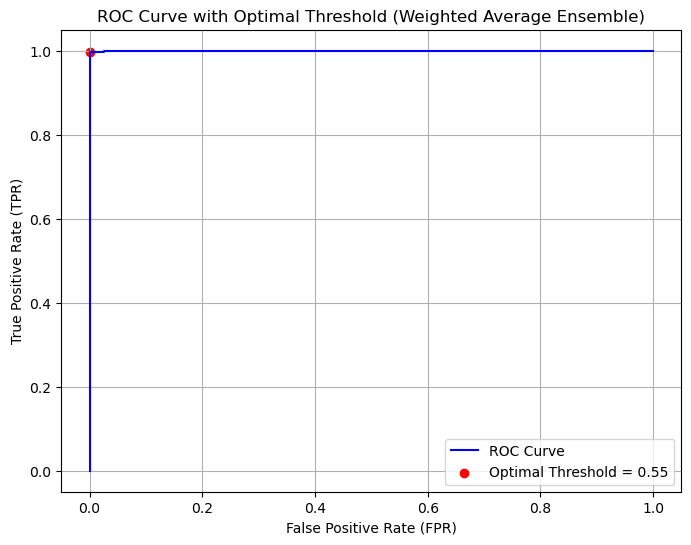

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Re-train models on the entire training dataset (X_best, y)
cat_cfecv_tuned.fit(X_best, y)
best_rf_model.fit(X_best, y)

# Generate predictions (probabilities) for the training dataset
y_proba_cat = cat_cfecv_tuned.predict_proba(X_best)[:, 1]
y_proba_rf = best_rf_model.predict_proba(X_best)[:, 1]

# Combine predictions using the weighted ensemble logic
weights = {'catboost': 0.7, 'random_forest': 0.3}
y_ensemble_proba_weighted = (
    weights['catboost'] * y_proba_cat +
    weights['random_forest'] * y_proba_rf
)

# Compute ROC curve on the training dataset
fpr, tpr, thresholds = roc_curve(y, y_ensemble_proba_weighted)

# Find the optimal threshold (closest to TPR=1, FPR=0)
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]

# Plot the ROC curve and mark the optimal threshold
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve', color='blue')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.title("ROC Curve with Optimal Threshold (Weighted Average Ensemble)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()
plt.grid()
plt.show()


In [51]:


# Load the test dataset
test_data = pd.read_csv('test.csv')

# Extract PatientID for output
patient_ids = test_data['PatientID']
test_features = test_data.drop(columns=['PatientID', 'DoctorInCharge'], errors='ignore')

# Subset test features to match models
test_features_best = test_features[X_best.columns]  # For CatBoost and Random Forest

# Train base models on the full dataset
cat_cfecv_tuned.fit(X_best, y)
best_rf_model.fit(X_best, y)

# Predictions storage
predictions = {}

# 1. Weighted Average Ensemble Predictions
y_proba_cat_test = cat_cfecv_tuned.predict_proba(test_features_best)[:, 1]
y_proba_rf_test = best_rf_model.predict_proba(test_features_best)[:, 1]

weights = {'catboost': 0.7, 'random_forest': 0.3}
y_ensemble_proba_weighted = (
    weights['catboost'] * y_proba_cat_test +
    weights['random_forest'] * y_proba_rf_test
)
# Apply the optimal threshold for Weighted Average Ensemble
optimal_threshold_weighted = 0.436
y_ensemble_pred_weighted = (y_ensemble_proba_weighted >= optimal_threshold_weighted).astype(int)
predictions["Weighted Average Ensemble"] = y_ensemble_pred_weighted

# 2. Stacking Ensemble Predictions
stacked_features_test = pd.DataFrame({
    'catboost': y_proba_cat_test,
    'random_forest': y_proba_rf_test
})
meta_model.fit(stacked_features_train, y)  # Train meta-model on full training data
y_meta_proba_test = meta_model.predict_proba(stacked_features_test)[:, 1]
# Apply the optimal threshold for Stacking Ensemble
optimal_threshold_stacking = 0.33
y_meta_pred_test = (y_meta_proba_test >= optimal_threshold_stacking).astype(int)
predictions["Stacking Ensemble"] = y_meta_pred_test

# 3. Voting Ensemble Predictions
voting_model = VotingClassifier(estimators=[
    ('catboost', cat_cfecv_tuned),
    ('random_forest', best_rf_model)
], voting='soft')
voting_model.fit(X_best, y)
y_voting_proba_test = voting_model.predict_proba(test_features_best)[:, 1]
# Apply the optimal threshold for Voting Ensemble
optimal_threshold_voting = 0.39
y_voting_pred_test = (y_voting_proba_test >= optimal_threshold_voting).astype(int)
predictions["Voting Ensemble"] = y_voting_pred_test

# Save predictions to separate files
for model_name, preds in predictions.items():
    output = pd.DataFrame({
        'PatientID': patient_ids,
        'Diagnosis': preds
    })
    file_name = f'predictions_{model_name.replace(" ", "_").lower()}.csv'
    output.to_csv(file_name, index=False)
    print(f"Predictions saved to '{file_name}'")


Predictions saved to 'predictions_weighted_average_ensemble.csv'
Predictions saved to 'predictions_stacking_ensemble.csv'
Predictions saved to 'predictions_voting_ensemble.csv'
